# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers@v4.45.1
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score
!pip install grad-cam

  Cloning https://github.com/huggingface/transformers (to revision v4.45.1) to /tmp/pip-req-build-3nwrbh_i
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-3nwrbh_i
  Running command git checkout -q 55e4b04b90a7cb7e41a16dd17efed6fcbd70be0f
  Resolved https://github.com/huggingface/transformers to commit 55e4b04b90a7cb7e41a16dd17efed6fcbd70be0f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.3 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.45.1-py3-none-any.whl size=9881229 sha256=2faf13f299b255e642b3003291d1908e3efeadcab27db56a9533e23e597129e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-gxba439g/wheels/07/92/57/66ffa33aa7d13ddca9d12dcc92092d6a806fc6eca7ea03b7b2
Successfully built transformers
  Attempting uninstall: tokenizers
    Found exist

# **Data Preprocessing , DataSet and DataLoaders**

In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
import re
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

In [4]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [5]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH      = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME   = "gpt2"
BATCH_SIZE       = 4
MAX_SEQ_LENGTH   = 512
IMAGE_SIZE       = 224

# Data Split Params (R2Gen-style ratios commonly used in IU-Xray literature)
TRAIN_RATIO      = 0.80  # train
VALID_RATIO      = 0.10  # val
TEST_RATIO       = 0.10  # test
RANDOM_STATE     = 42
RAMDOM_SEED      = 9223
assert abs(TRAIN_RATIO + VALID_RATIO + TEST_RATIO - 1.0) < 1e-6, "Ratios must sum to 1."

In [6]:
import pandas as pd
import re

# --- Step 1: Load your new CSV file (No change) ---
CHEXPERT_CSV_PATH = "/kaggle/input/iu-chexpert-labels/final_labeled_reports_with_study_id.csv"
labels_df = pd.read_csv(CHEXPERT_CSV_PATH)

# <<< FIX 1: Define BOTH the source and target label orders >>>
# This is the order of columns as they appear in your new CSV file.
SOURCE_ORDER_FROM_CSV = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Lesion',
    'Lung Opacity',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices'
]

# This is the correct order that your pre-trained MambaVision model expects.
TARGET_MODEL_ORDER = [
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
    'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
    'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding'
]

# --- Step 2: Extract Study Numbers (No change) ---
def get_study_num_from_id(study_id):
    match = re.search(r'(\d+)', str(study_id))
    if match:
        return match.group(1)
    return None

labels_df['study_num'] = labels_df['study_id'].apply(get_study_num_from_id)
labels_df.dropna(subset=['study_num'], inplace=True)
labels_df.set_index('study_num', inplace=True)

# --- Step 3: Create a lookup dictionary with named labels (No change) ---
# We load the data using the CSV's column order first.
# The result is a dict of dicts: {'study_id': {'No Finding': 1.0, 'Cardiomegaly': 0.0, ...}}
label_lookup_by_name = labels_df[SOURCE_ORDER_FROM_CSV].fillna(0.0).to_dict(orient='index')


# <<< FIX 2: Create the final lookup by reordering the labels for each study >>>
# This new step ensures the final list of labels is in the TARGET_MODEL_ORDER.
label_lookup = {}
for study_num, labels_dict in label_lookup_by_name.items():
    # For each study, build a new list by looking up the labels in the correct target order.
    reordered_labels = [labels_dict[label_name] for label_name in TARGET_MODEL_ORDER]
    label_lookup[study_num] = reordered_labels

print(f"Loaded and reordered {len(label_lookup)} studies with CheXpert labels.")

# --- Verification Step ---
# Let's print an example to prove the reordering worked correctly.
if label_lookup:
    first_key = next(iter(label_lookup))
    
    print("\n--- Verification ---")
    print(f"Original order from CSV: {SOURCE_ORDER_FROM_CSV}")
    print(f"Target order for Model:  {TARGET_MODEL_ORDER}")
    
    print(f"\nOriginal Labels for study '{first_key}':")
    print({k: v for k, v in label_lookup_by_name[first_key].items()})

    print(f"\nReordered Label Vector for study '{first_key}' (this will be fed to the model):")
    print(label_lookup[first_key])

Loaded and reordered 3927 studies with CheXpert labels.

--- Verification ---
Original order from CSV: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
Target order for Model:  ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding']

Original Labels for study '1':
{'No Finding': 1.0, 'Enlarged Cardiomediastinum': 0.0, 'Cardiomegaly': 0.0, 'Lung Lesion': 0.0, 'Lung Opacity': 0.0, 'Edema': 0.0, 'Consolidation': 0.0, 'Pneumonia': 0.0, 'Atelectasis': 0.0, 'Pneumothorax': 0.0, 'Pleural Effusion': 0.0, 'Pleural Other': 0.0, 'Fracture': 0.0, 'Support Devices': 0.0}

Reordered Label Vector for study '1' (this will be fed to the model):
[0.0, 0.0

In [7]:
# 2) Cleaning, patient-id extraction, manifest builder (multi-view + patient_id)

import re

_punct_to_remove = re.compile(r'[?*;!%^&_+():\[\]{}"\\/]+')
_multiple_spaces = re.compile(r'\s{2,}')
_multiple_periods = re.compile(r'\.{2,}')

def clean_text(text):
    if not text or not isinstance(text, str):
        return ""

    text = text.lower().strip()
    text = text.replace('xxxx', '') # Remove placeholder
    text = text.replace('\n', ' ').replace('\r', ' ') # Normalize whitespace

    # Keep commas and periods, but remove other punctuation
    text = _punct_to_remove.sub('', text)
    
    # Standardize spacing around periods and commas
    text = re.sub(r'\s*([,.])\s*', r' \1 ', text)
    
    # Collapse multiple spaces and periods
    text = _multiple_spaces.sub(' ', text)
    text = _multiple_periods.sub(' . ', text) # Ensure space around periods

    return text.strip()

def extract_patient_id_from_xml(xml_path):
    """
    Derive a stable patient_id for IU X-ray:
    - Prefer deriving from the first parentImage id 'CXR####_IM-...'
      -> returns 'PID_####'
    - Fallback to numeric digits in the XML filename stem.
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        parent = root.find(".//parentImage")
        if parent is not None:
            pid_guess = parent.get('id') or ""
            m = re.search(r'CXR(\d+)', pid_guess)
            if m:
                return f"PID_{m.group(1)}"
    except Exception:
        pass
    stem = os.path.splitext(os.path.basename(xml_path))[0]
    m2 = re.search(r'(\d+)', stem)
    return f"PID_{m2.group(1) if m2 else stem}"

def create_data_manifest(xml_dir, img_dir, tokenizer=None, max_seq_length=512):
    """
    Build per-study multi-view manifest with patient_id.
    Returns list of dicts:
      {
        'patient_id': str,
        'image_paths': [list of .png paths for one study],
        'report_text': str   # clean concatenated findings + impression
      }
    """
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in tqdm(xml_files, desc="Scanning XMLs"):
        try:
            study_num = os.path.splitext(os.path.basename(xml_file))[0]
            tree = ET.parse(xml_file)
            root = tree.getroot()

            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node   = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text   = clean_text(findings_node.text   if findings_node   is not None else "")
            if not findings_text and not impression_text:
                continue

            full_report = f"<SECTION_FINDINGS> {findings_text} <SECTION_IMPRESSION> {impression_text} <|endoftext|>"
            image_nodes = root.findall(".//parentImage")
            seen = set()
            image_paths = []
            for node in image_nodes:
                image_filename = (node.get('id') or "") + ".png"
                if not image_filename or image_filename in seen:
                    continue
                seen.add(image_filename)
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    image_paths.append(image_path)
            if not image_paths:
                continue

            patient_id = extract_patient_id_from_xml(xml_file)
            chexpert_labels = label_lookup.get(study_num, [0.0] * len(CHEXPERT_LABELS))
            manifest.append({
                'patient_id': patient_id,
                'image_paths': image_paths,
                'report_text': full_report,
                'chexpert_labels': chexpert_labels
            })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
    return manifest


In [8]:


class IUXRayDataset(Dataset):
    def __init__(self, manifest, tokenizer, image_transform=None, max_seq_length=512):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_paths = item['image_paths']

        image_tensors = []
        for p in image_paths:
            # Load image with PIL and convert to RGB
            image = Image.open(p).convert('RGB')
            
            if self.image_transform:
                # Convert PIL image to NumPy array for Albumentations
                image_np = np.array(image)
                # Apply transformations
                transformed = self.image_transform(image=image_np)
                image_tensor = transformed['image']
            else:
                # Default minimal transform if none provided
                image_tensor = transforms.ToTensor()(image)
            
            image_tensors.append(image_tensor)

        # Tokenization remains the same
        tokenized = self.tokenizer(
            report_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_seq_length,
            return_tensors="pt",
            add_special_tokens=True,
        )

        input_ids = tokenized["input_ids"].squeeze(0)
        attention_mask = tokenized["attention_mask"].squeeze(0)
        labels = input_ids.clone()
        labels[attention_mask == 0] = -100

        return {
            "images": image_tensors,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "image_paths": image_paths,
            "patient_id": item.get("patient_id", None),
            "chexpert_labels": torch.tensor(item['chexpert_labels'], dtype=torch.float)
        }

In [9]:
from transformers import GPT2TokenizerFast

# --- THIS IS THE KEY CHANGE ---

# 1. Define the path to your new tokenizer directory
TOKENIZER_PATH = "/kaggle/input/mimic-cxr-tokenizer" # Or the path where you saved it

# 2. Load your custom tokenizer directly from that path
#    All your special tokens and pad_token settings are already saved in this folder!
print(f"Loading custom tokenizer from: {TOKENIZER_PATH}")
tokenizer = GPT2TokenizerFast.from_pretrained(TOKENIZER_PATH)

# # --- End of Change ---


# # Sanity check to verify it loaded correctly
# print("\n--- Verifying Custom Tokenizer ---")
# print(f"Tokenizer vocabulary size: {len(tokenizer)}")
# print(f"Pad token: '{tokenizer.pad_token}', ID: {tokenizer.pad_token_id}")
# print(f"Special tokens map: {tokenizer.special_tokens_map}")

# # Test a medical term to see the difference!
# medical_term = "cardiomegaly"
# tokens_before = GPT2TokenizerFast.from_pretrained('gpt2').tokenize(medical_term)
# tokens_after = tokenizer.tokenize(medical_term)

# print(f"\nTokenization of '{medical_term}':")
# print(f"  - Before (Standard GPT-2): {tokens_before}")
# print(f"  - After (Custom Tokenizer): {tokens_after}") # Should be a single token or fewer tokens
# print("-" * 30)

Loading custom tokenizer from: /kaggle/input/mimic-cxr-tokenizer


In [10]:
def make_collate_fn(pad_token_id: int):
    def _collate(batch):
        if len(batch) == 0:
            raise ValueError("Empty batch received by collate_fn.")
        image_lists = [it['images'] for it in batch]
        image_paths_lists = [it['image_paths'] for it in batch]
        input_ids_list = [it['input_ids'] for it in batch]
        labels_list = [it['labels'] for it in batch]
        chexpert_labels = torch.stack([it['chexpert_labels'] for it in batch])
        max_views = max(len(images) for images in image_lists)

        batch_images, mask = [], []
        for images in image_lists:
            if len(images) == 0:
                raise ValueError("Found a sample with zero images/views. Check your manifest.")
            last_image = images[-1]
            padded = images + [last_image] * (max_views - len(images))
            batch_images.append(torch.stack(padded))  # (V,3,H,W)
            mask.append([1] * len(images) + [0] * (max_views - len(images)))

        batch_images = torch.stack(batch_images)                # (B,V,3,H,W)
        view_mask   = torch.tensor(mask, dtype=torch.bool)      # (B,V)
        input_ids     = torch.stack([it['input_ids'] for it in batch])
        attention_mask= torch.stack([it['attention_mask'] for it in batch])
        labels        = torch.stack([it['labels'] for it in batch]).clone()  # (B,T)

        labels[attention_mask == 0] = -100

        return {
            'images': batch_images,
            'view_mask': view_mask,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'image_paths': image_paths_lists,
            'chexpert_labels': chexpert_labels
        }
    return _collate

collate_fn = make_collate_fn(tokenizer.pad_token_id)

# **Loaded Data Visualization**

In [11]:

import os, random, numpy as np, torch

def set_global_seed(seed: int = 9223, deterministic: bool = True):
    # Python & NumPy
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN / deterministic behavior
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        # Slightly faster but less reproducible
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

    # Torch compile caches, dataloader reproducibility knobs (optional)
    os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")  # for determinism on some ops
    # If using torch>=2.0, some ops may still be nondeterministic; see PyTorch docs.

# Call once, before any randomness-dependent code (tokenizer/dataloaders/models)
GLOBAL_SEED = 9223
set_global_seed(GLOBAL_SEED, deterministic=True)


In [12]:
def _worker_init_fn(worker_id):
    # Ensures each worker has a distinct, reproducible seed
    worker_seed = (GLOBAL_SEED + worker_id) % (2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(GLOBAL_SEED)


In [13]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the image size your MambaVision model expects
IMAGE_SIZE = 224 # Or 384, etc.

# This is a balanced and safe pipeline for training
train_transform = A.Compose([
    # 1. Safely resize the image. This is better than a random crop which might
    #    cut out important pathologies.
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),

    # 2. Simulate variations in patient positioning. These are the most
    #    important and safest geometric augmentations for X-rays.
    A.ShiftScaleRotate(
        shift_limit=0.05,      # Max 5% shift in x/y
        scale_limit=0.1,       # Max 10% zoom in/out
        rotate_limit=15,       # Max 15 degrees rotation
        p=0.9                    # Apply this transform 90% of the time
    ),

    # 3. Flip the image horizontally. This is a standard and safe augmentation.
    A.HorizontalFlip(p=0.5),

    # 4. Simulate variations in X-ray exposure and contrast.
    A.RandomBrightnessContrast(
        brightness_limit=0.2,  # Max 20% change in brightness
        contrast_limit=0.2,    # Max 20% change in contrast
        p=0.8                    # Apply this 80% of the time
    ),

    # 5. (Optional) Add a small amount of Gaussian noise.
    # A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),

    # 6. Normalize and convert to a PyTorch tensor.
    #    IMPORTANT: X-rays are 1-channel, but pretrained models expect 3 channels.
    #    Your data loader must duplicate the single channel 3 times *before* this step.
    A.Normalize(
        mean=[0.485, 0.456, 0.406], # Standard ImageNet mean
        std=[0.229, 0.224, 0.225]   # Standard ImageNet std
    ),
    ToTensorV2(),
])

# The validation transform should be minimal: just resize and normalize.
val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Scanning 3955 XML files to create manifest...


Scanning XMLs: 100%|██████████| 3955/3955 [00:51<00:00, 76.33it/s]


Total multi-view studies in manifest: 3826

Data successfully split (patient-level, multi-view, no leakage):
Unique patients total: 3826
Train patients: 3061, Val patients: 383, Test patients: 382
Training studies:   3061
Validation studies: 383
Test studies:       382

--- Creating Pathology-Aware Weighted Sampler ---
Sampler created for 3061 training samples.

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---
Batch keys: dict_keys(['images', 'view_mask', 'input_ids', 'attention_mask', 'labels', 'image_paths', 'chexpert_labels'])
Image tensor shape:      torch.Size([4, 3, 3, 224, 224])
View mask shape:         torch.Size([4, 3])
Input IDs tensor shape:  torch.Size([4, 512])
Attention mask shape:    torch.Size([4, 512])
Labels tensor shape:     torch.Size([4, 512])
First study image_paths: ['/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1496_IM-0320-1001.png', '/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1496_IM-0320-2001.png']


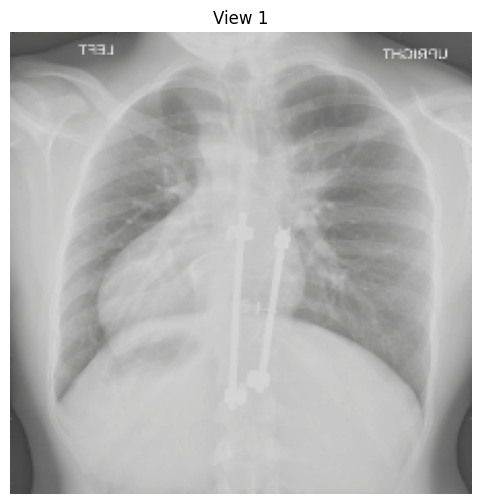


--- Sample Report (Decoded) ---
 status post posterior spinal fusion with stable appearance of the orthopedic . pectus carinatum . stable mild cardiomegaly and increased lung vascularity . clear lungs .  stable mild cardiomegaly and increased lung vascularity . clear lungs . 

-----sample chexpet label------
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
--------------------------------------------------


In [14]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms

CHEXPERT_LABELS= [
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
    'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
    'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding'
]



# --- Create manifest for multi-view ---
# 5) Build manifest and patient-level split

full_manifest = create_data_manifest(
    XML_REPORTS_PATH,
    IMAGES_PATH,
    tokenizer,
    max_seq_length=MAX_SEQ_LENGTH
)
print(f"Total multi-view studies in manifest: {len(full_manifest)}")

# Unique patients and shuffled split
all_patients = sorted({m['patient_id'] for m in full_manifest})
random.Random(RANDOM_STATE).shuffle(all_patients)

n_patients = len(all_patients)
n_train = int(round(TRAIN_RATIO * n_patients))
n_val   = int(round(VALID_RATIO * n_patients))
n_test  = n_patients - n_train - n_val

train_patients = set(all_patients[:n_train])
val_patients   = set(all_patients[n_train:n_train+n_val])
test_patients  = set(all_patients[n_train+n_val:])

def filter_by_patients(manifest, keep_patients):
    return [m for m in manifest if m['patient_id'] in keep_patients]

train_manifest = filter_by_patients(full_manifest, train_patients)
val_manifest   = filter_by_patients(full_manifest, val_patients)
test_manifest  = filter_by_patients(full_manifest, test_patients)

print("\nData successfully split (patient-level, multi-view, no leakage):")
print(f"Unique patients total: {n_patients}")
print(f"Train patients: {len(train_patients)}, Val patients: {len(val_patients)}, Test patients: {len(test_patients)}")
print(f"Training studies:   {len(train_manifest)}")
print(f"Validation studies: {len(val_manifest)}")
print(f"Test studies:       {len(test_manifest)}")


# --- Create Datasets and DataLoaders for multi-view ---
# 6) Datasets and DataLoaders

train_dataset = IUXRayDataset(train_manifest, tokenizer, train_transform, max_seq_length=MAX_SEQ_LENGTH)
val_dataset   = IUXRayDataset(val_manifest,   tokenizer, val_transform, max_seq_length=MAX_SEQ_LENGTH)
test_dataset  = IUXRayDataset(test_manifest,  tokenizer, val_transform, max_seq_length=MAX_SEQ_LENGTH)

import numpy as np
from torch.utils.data import WeightedRandomSampler

# PREREQUISITE: Make sure you have defined this list of labels somewhere globally
# This must match the order of labels in your manifest's 'chexpert_labels' list.


print("\n--- Creating Pathology-Aware Weighted Sampler ---")

# 1. Calculate the prevalence of each pathology in the training set
label_counts = np.sum([item['chexpert_labels'] for item in train_manifest], axis=0)
total_samples = len(train_manifest)
prevalence = label_counts / (total_samples + 1e-8) # Add epsilon for stability

# 2. Calculate a weight for each label (inverse frequency)
label_weights = 1.0 / prevalence
label_weights = np.clip(label_weights, 1.0, 20.0) # Cap weights to prevent extreme values

# 3. For each sample, its weight is the weight of its rarest positive label
sample_weights = []
no_finding_idx = CHEXPERT_LABELS.index('No Finding')

for item in train_manifest:
    labels = np.array(item['chexpert_labels'])
    if labels[no_finding_idx] == 1:
        sample_weights.append(1.0) # Baseline weight for "normal" studies
        continue
    
    positive_label_indices = np.where(labels[:-1] > 0)[0]
    
    if len(positive_label_indices) == 0:
        sample_weights.append(1.0) # Fallback for edge cases
    else:
        rarest_finding_weight = np.max(label_weights[positive_label_indices])
        sample_weights.append(rarest_finding_weight)

# 4. Create the sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print(f"Sampler created for {len(sample_weights)} training samples.")


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,worker_init_fn=_worker_init_fn,
    generator=g,
    persistent_workers=True, pin_memory=True,sampler=sampler,drop_last=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,worker_init_fn=_worker_init_fn,
    generator=g,
    persistent_workers=True, pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,worker_init_fn=_worker_init_fn,
    generator=g,
    persistent_workers=True, pin_memory=True,
)

print("\nPyTorch DataLoaders are ready!")

print("\n--- Verifying a sample batch from the train_loader ---")

# --- Fetch one batch
# 7) Quick sanity check: one batch + visualize views

sample_batch = next(iter(train_loader))
print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['images'].shape}")       # (B,V,3,H,W)
print(f"View mask shape:         {sample_batch['view_mask'].shape}")    # (B,V)
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")    # (B,T)
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:     {sample_batch['labels'].shape}")
print(f"First study image_paths: {sample_batch['image_paths'][0]}")

# Visualize all (non-padded) views for a random study in the batch
idx_to_show = random.randint(0, sample_batch['images'].size(0) - 1)
images_to_show = sample_batch['images'][idx_to_show]  # (V,3,H,W)
view_mask = sample_batch['view_mask'][idx_to_show]    # (V,)
num_views = images_to_show.size(0)

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

valid_indices = [i for i in range(num_views) if view_mask[i].item() == 1]
plt.figure(figsize=(6 * len(valid_indices), 6))
for plot_idx, i in enumerate(valid_indices, start=1):
    img_tensor = images_to_show[i]
    img_display = (img_tensor * std) + mean
    img_display = transforms.ToPILImage()(img_display.clamp(0, 1))
    plt.subplot(1, len(valid_indices), plot_idx)
    plt.imshow(img_display)
    plt.title(f"View {i+1}")
    plt.axis('off')
plt.show()

# Decode report for that study
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)
labels = sample_batch['chexpert_labels'][idx_to_show] 
print("\n--- Sample Report (Decoded) ---")
print(report_display)
print("\n-----sample chexpet label------")
print(labels) 
print("-" * 50)



# **MambaVision**

In [15]:
import torch
import torch.nn as nn
from transformers import AutoModel

class MambaVisionEncoder(nn.Module):
    """
    A unified MambaVision class that can be used for multi-label classification
    (for pre-training) or as a powerful feature encoder for report generation.
    """
    def __init__(self, model_name="nvidia/MambaVision-S-1K", num_labels=14, device="cuda", dropout_rate=0.3,
                 for_report_generation=False, trained_classifier_path=None):
        super().__init__()
        self.device = device
        self.for_report_generation = for_report_generation

        # 1. Load the base MambaVision model from Hugging Face
        self.encoder = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True
        ).to(device)

        # 2. Infer hidden dimension from the model itself
        self.encoder.eval()
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224, device=device)
            pooled_feats, _ = self.encoder(dummy)
            hidden_dim = pooled_feats.shape[-1]

        print(f"Inferred hidden dimension: {hidden_dim}")

        # 3. Define the classification head (only used if for_report_generation is False)
        self.label_head = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_labels)
        ).to(device)

        # 4. Load pre-trained weights if a path is provided (with robust loading)
        if trained_classifier_path:
            print(f"Loading pre-trained classifier weights from: {trained_classifier_path}")
            checkpoint = torch.load(trained_classifier_path, map_location=device)
            # Handle both raw state_dict and checkpoint dictionaries
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint
            
            # Handle weights from a compiled model (_orig_mod prefix)
            unwrapped_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
            
            # Use strict=False to gracefully handle loading only encoder weights
            # if the saved model doesn't have the classification head.
            self.load_state_dict(unwrapped_state_dict, strict=False)
            print("Successfully loaded pre-trained weights.")

        # 5. Set initial state
        self.encoder.eval()
        self.frozen = False
        self.freeze() # Start with the encoder frozen by default

    def forward(self, image_tensor):
        """
        Forward pass behavior depends on the 'for_report_generation' flag.
        """
        pooled_feats, features = self.encoder(image_tensor)
        
        if self.for_report_generation:
            # Mode 1: Report Generation - Return patch features
            last_stage_features = features[-1]
            patch_tokens = last_stage_features.flatten(2).permute(0, 2, 1)
            return patch_tokens, features
        else:
            # Mode 2: Classification - Return logits
            logits = self.label_head(pooled_feats)
            return logits, {'pooled': pooled_feats, 'patch': features}

    def freeze(self):
        self.frozen = True
        self.encoder.eval()
        print("Freezing encoder layers.")
        for param in self.encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        self.frozen = False
        self.encoder.train()
        print("Unfreezing all encoder layers.")
        for param in self.encoder.parameters():
            param.requires_grad = True

    def unfreeze_encoder_top_layers(self, num_levels_to_unfreeze=1):
        if num_levels_to_unfreeze < 0 or num_levels_to_unfreeze > len(self.encoder.model.levels):
            raise ValueError("num_levels_to_unfreeze must be between 0 and 4.")

        self.freeze()
        if num_levels_to_unfreeze > 0:
            print(f"Unfreezing the last {num_levels_to_unfreeze} encoder level(s)...")
            self.frozen = False
            self.encoder.train()
            for i in range(num_levels_to_unfreeze):
                level_to_unfreeze = self.encoder.model.levels[-(i + 1)]
                for param in level_to_unfreeze.parameters():
                    param.requires_grad = True
        else:
            print("Encoder remains frozen.")

Instantiating model architecture...


config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-S-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-S-1K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Inferred hidden dimension: 768
Loading pre-trained classifier weights from: /kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth
Successfully loaded pre-trained weights.
Freezing encoder layers.
Hook registered on: Attention

--- Visualizing 3 samples ---


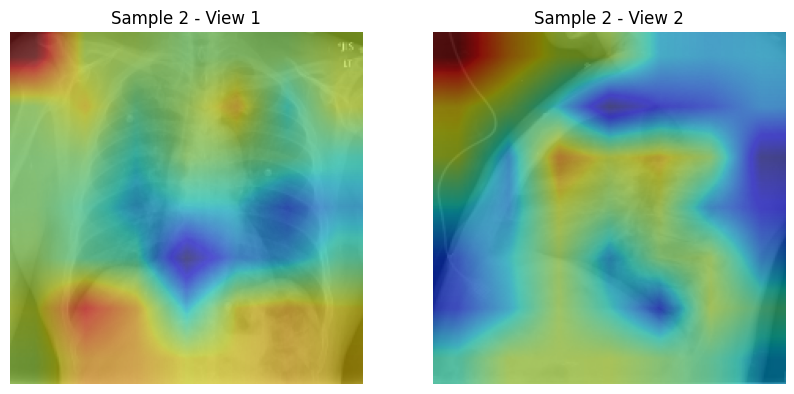

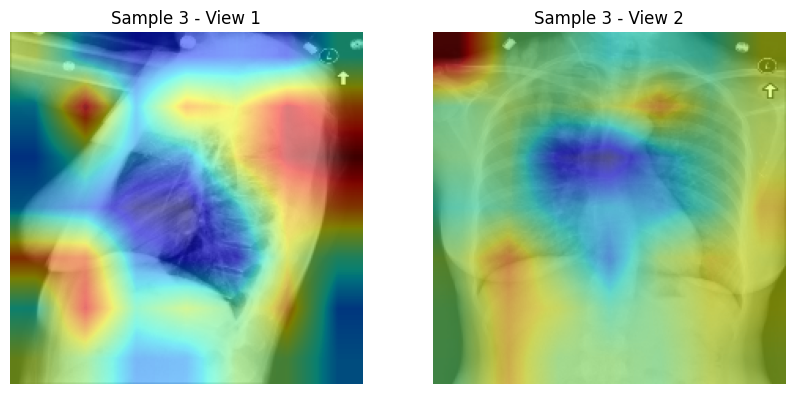

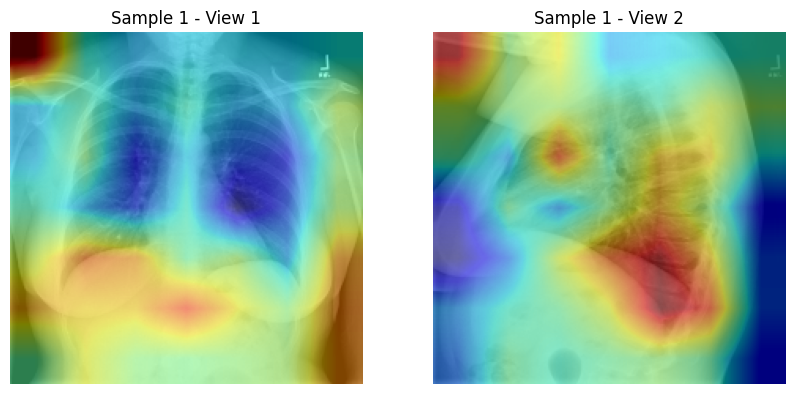


Visualization complete. Hook removed successfully.


In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import random

# --- Global storage ---
final_feature_map = None
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# --- Hook to capture patch features ---
def forward_hook(module, input, output):
    global final_feature_map
    final_feature_map = output.detach()  # [1, N, C]

# --- Load model ---
print("Instantiating model architecture...")
inference_model = MambaVisionEncoder(
    model_name="nvidia/MambaVision-S-1K",
    for_report_generation=False,
    trained_classifier_path="/kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth",
    device=DEVICE
).to(DEVICE)
inference_model.eval()

# --- Register hook on last mixer block ---
target_layer = inference_model.encoder.model.levels[3].blocks[-1].mixer
fwd_hook = target_layer.register_forward_hook(forward_hook)
print(f"Hook registered on: {target_layer.__class__.__name__}")

# --- Mean/Std for denorm ---
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(DEVICE)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(DEVICE)

# --- Visualization loop ---
num_samples_to_show = 3
print(f"\n--- Visualizing {num_samples_to_show} samples ---")

sample_batch = next(iter(test_loader))
images_batch = sample_batch["images"]  # (B, V, 3, H, W)
view_mask = sample_batch.get("view_mask", None)

selected_indices = random.sample(range(images_batch.size(0)), num_samples_to_show)

for idx in selected_indices:
    views = []
    heatmaps = []

    for v in range(images_batch.size(1)):
        if view_mask is not None and view_mask[idx, v] == 0:
            continue

        img_tensor = images_batch[idx, v].unsqueeze(0).to(DEVICE)  # [1,3,H,W]

        # --- Forward pass only ---
        _ = inference_model(img_tensor)  # triggers hook

        # --- Process patch features to 2D heatmap ---
        fmap = final_feature_map[0]  # [N, C]
        N, C = fmap.shape
        h = w = int(np.sqrt(N))
        fmap_2d = fmap.reshape(h, w, C)   # [H, W, C]

        # Convert to heatmap: mean across channels
        heatmap = fmap_2d.mean(axis=2).cpu().numpy()
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)  # normalize
        heatmap = F.interpolate(torch.tensor(heatmap).unsqueeze(0).unsqueeze(0),
                                size=(224, 224), mode='bilinear', align_corners=False).squeeze().numpy()

        # Denormalize image for display
        disp_img = (images_batch[idx, v].cpu() * std.cpu() + mean.cpu()).clamp(0, 1)
        pil_img = transforms.ToPILImage()(disp_img)

        views.append(pil_img)
        heatmaps.append(heatmap)

    # --- Plot ---
    num_views = len(views)
    plt.figure(figsize=(5*num_views, 10))
    for i, (orig, hmap) in enumerate(zip(views, heatmaps)):
        plt.subplot(1, num_views, i+1)
        plt.imshow(orig)
        plt.imshow(hmap, cmap='jet', alpha=0.5)  # overlay heatmap
        plt.title(f"Sample {idx} - View {i+1}")
        plt.axis('off')
    plt.show()

# --- Cleanup ---
fwd_hook.remove()
print("\nVisualization complete. Hook removed successfully.")

# **Main Block**

In [17]:
import torch
import torch.nn as nn

class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps

    def forward(self, x, y):
        # x: logits, y: targets
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))

        # Asymmetric Focusing
        pt_pos = xs_pos * y
        pt_neg = xs_neg * (1 - y)
        pt = pt_pos + pt_neg
        
        one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
        one_sided_w = torch.pow(1 - pt, one_sided_gamma)
        
        los_pos = one_sided_w * los_pos
        los_neg = one_sided_w * los_neg

        loss = - (los_pos + los_neg)
        return loss.mean() # Return mean loss across batch

In [18]:
import torch
import torch.nn as nn
from transformers import GPT2Config, GPT2LMHeadModel

# A new wrapper class to use the new fusion module
class VisionLanguageWrapper_CrossAttention(nn.Module):
    def __init__(self, vision_encoder, gpt2_model, vision_dim, text_embed_dim, device='cuda'):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.gpt2 = gpt2_model
        self.device = torch.device(device)
        self.config = gpt2_model.config
        self.classification_loss_fn = AsymmetricLoss(gamma_neg=4, gamma_pos=1)
        self.vision_projector = nn.Linear(vision_dim, text_embed_dim)

        ### NOVELTY 1/3: Define the Gating Network ###
        # This small MLP learns to create a "clinical gate" from the CheXpert labels.
        # It translates high-level pathology concepts into a modulation signal for the visual features.
        num_chexpert_labels = 14
        self.film_generator = nn.Sequential(
                nn.Linear(num_chexpert_labels, 256),
                nn.ReLU(),
                # It now outputs TWICE the embedding dimension to create both a scale and shift vector.
                nn.Linear(256, text_embed_dim * 2)
            ).to(self.device)

    def forward(self, images, input_ids, attention_mask=None, labels=None, view_mask=None, chexpert_labels=None):
        B, V, C, H, W = images.shape
        images_flat = images.view(B * V, C, H, W)
    
        # === 1. GET AND PROJECT PATCH FEATURES ===
        self.vision_encoder.for_report_generation = True
        patch_feats_flat, _ = self.vision_encoder(images_flat)
    
        if patch_feats_flat.dim() != 3:
            raise RuntimeError(f"Expected 3D patch features, but got shape {patch_feats_flat.shape}.")
    
        _, Num_Patches, Vision_Dim = patch_feats_flat.shape
        patch_feats_seq = patch_feats_flat.reshape(B, V * Num_Patches, Vision_Dim)
        encoder_hidden_states = self.vision_projector(patch_feats_seq)
    
        ### NOVELTY 2/3: Apply the Clinical Gate to Visual Features ###
        # Before feeding the visual features to the decoder, we modulate them based on the
        # identified pathologies (CheXpert labels).
        if chexpert_labels is not None:
        # Step A: Generate the FiLM parameters (gamma and beta) from the labels.
            film_params = self.film_generator(chexpert_labels)
    
            # Step B: Split the output into two separate vectors.
            gamma, beta = torch.chunk(film_params, 2, dim=-1)
    
            # Step C: Reshape for broadcasting over the sequence of visual patches.
            gamma = gamma.unsqueeze(1)
            beta = beta.unsqueeze(1)
    
            # Step D: Apply the modulation. This is the key change.
            encoder_hidden_states = (encoder_hidden_states * gamma) + beta
        
        # Create attention mask for the (potentially multi-view) visual features
        if view_mask is not None:
            encoder_attention_mask = view_mask.unsqueeze(-1).expand(-1, -1, Num_Patches).reshape(B, V * Num_Patches)
        else:
            encoder_attention_mask = torch.ones_like(encoder_hidden_states[:, :, 0])
    
        # === 2. GET GENERATION LOSS ===
        # The decoder now receives the *gated* visual features, making its generation
        # process clinically-aware from the start.
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            encoder_hidden_states=encoder_hidden_states, # This is now the gated version
            encoder_attention_mask=encoder_attention_mask,
            return_dict=True
        )
        generation_loss = outputs.loss
    
        # === 3. GET CLASSIFICATION LOSS (Unchanged) ===
        classification_loss = torch.tensor(0.0, device=self.device) # Ensure it's a tensor on the correct device
        if chexpert_labels is not None:
            self.vision_encoder.for_report_generation = False
            logits_flat, _ = self.vision_encoder(images_flat)
            logits_study_view = logits_flat.view(B, V, -1)
    
            if view_mask is not None:
                logits_study_view = logits_study_view * view_mask.unsqueeze(-1).float()
                study_logits = logits_study_view.sum(dim=1) / view_mask.sum(dim=1).unsqueeze(-1).clamp(min=1)
            else:
                study_logits = logits_study_view.mean(dim=1)

            classification_loss = self.classification_loss_fn(study_logits, chexpert_labels)
            self.vision_encoder.for_report_generation = True
    
        # === 4. COMBINE THE LOSSES (Unchanged) ===
        lambda_clf = 1.0
        total_loss = generation_loss + (lambda_clf * classification_loss)
    
        return {
            'loss': total_loss,
            'generation_loss': generation_loss,
            'classification_loss': classification_loss,
            'logits': outputs.logits
        }

    ### NOVELTY 3/3: Update the helper method to include gating network parameters ###
    def adapter_parameters(self):
        """
        Returns parameters for NEW adapter components: the vision projector,
        the gating network, and the cross-attention layers in GPT-2.
        This ensures the new gating network is trained with the appropriate learning rate.
        """
        # Start with the parameters of the projector and the new gating network
        adapter_params = list(self.vision_projector.parameters()) + list(self.film_generator.parameters())
        
        # Add the cross-attention parameters from the decoder
        for name, p in self.gpt2.named_parameters():
            if 'crossattention' in name.lower():
                if p.requires_grad:
                    adapter_params.append(p)
        
        # Using a set ensures that we don't have duplicate parameters
        return list(set(adapter_params))

    def vision_encoder_parameters(self):
        """Returns all trainable parameters of the vision encoder."""
        return [p for p in self.vision_encoder.parameters() if p.requires_grad]

    def lora_parameters(self):
        """Returns all trainable LoRA parameters."""
        return [p for n, p in self.gpt2.named_parameters() if 'lora' in n and p.requires_grad]
        
    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')


    def gpt2_body_parameters(self):
        """
        Returns the main GPT-2 transformer block parameters, EXCLUDING adapters.
        This is necessary to avoid parameter overlap in the optimizer.
        """
        body_params = []
        adapter_param_ids = {id(p) for p in self.adapter_parameters()}
        
        for name, p in self.gpt2.named_parameters():
            if id(p) not in adapter_param_ids and p.requires_grad:
                body_params.append(p)
                
        return body_params

    def vision_encoder_parameters(self):
        """Returns all parameters of the vision encoder."""
        return [p for p in self.vision_encoder.parameters() if p.requires_grad]

    def freeze_decoder_body(self):
        """Freezes all parts of GPT-2 except cross-attention and the LM head."""
        for name, p in self.gpt2.named_parameters():
            if 'crossattention' not in name.lower() and 'lm_head' not in name.lower():
                p.requires_grad = False

In [19]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 768,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)



In [20]:
from types import SimpleNamespace
from pathlib import Path

train_config = SimpleNamespace(
    # --- Phase Control ---
    epochs = 60,
    # --- Learning Rates for Different Phases ---
    lr_fusion = 1e-4,    # For fusion module in both phases
    lr_lora = 5e-5,      # For LoRA adapters in both phases
    lr_encoder = 5e-6,   # <-- NEW: VERY LOW LR for the vision encoder in Phase 2

    # --- General Optimizer & Scheduler Settings ---
    device = 'cuda',
    model_path = Path('vl_captioner_staged_v8'),
    batch_size = 8,
    optim = 'AdamW',
    weight_decay = 0.1,
    amsgrad = False,
    lr_scheduler = 'OneCycleLR',
    T_max = 60, # Match total epochs
    eta_min = 1e-7,

    # --- Other Training Settings ---
    grad_accum_steps = 4,
    use_amp = True,
    wandb_project = "vl_captioner",
    wandb_run_name = "staged_v5_full_finetune",
    use_wandb = False,
)

In [21]:
import torch
import torch.nn as nn

def reinitialize_cross_attention_weights(model):
    """
    Properly initializes the weights of NEW cross-attention layers using Kaiming Normal.
    This should be called BEFORE applying PEFT/LoRA.
    """
    print("\n--- Re-initializing cross-attention layers with Kaiming Normal ---")
    
    reinitialized_count = 0
    # Iterate through the transformer blocks of the GPT-2 model
    for layer in model.gpt2.transformer.h:
        # Check if the layer has the cross-attention module
        if hasattr(layer, 'crossattention'):
            # Initialize the main attention projection weights (query, key, value combined)
            nn.init.kaiming_normal_(layer.crossattention.c_attn.weight, mode='fan_in', nonlinearity='relu')
            # Initialize the output projection weights
            nn.init.kaiming_normal_(layer.crossattention.c_proj.weight, mode='fan_in', nonlinearity='relu')
            
            # Initialize biases to zero, which is standard practice
            if layer.crossattention.c_attn.bias is not None:
                nn.init.zeros_(layer.crossattention.c_attn.bias)
            if layer.crossattention.c_proj.bias is not None:
                nn.init.zeros_(layer.crossattention.c_proj.bias)
            
            reinitialized_count += 1
    
    if reinitialized_count > 0:
        print(f"  - Successfully re-initialized {reinitialized_count} cross-attention blocks.")
    else:
        print("  - Warning: No cross-attention blocks were found to re-initialize.")
    print("--- Cross-attention re-initialization complete ---")

In [22]:
def initialize_film_generator(film_generator_model):
    """
    Initializes the final layer of the FiLM generator to produce an
    identity transformation (gamma=1, beta=0) at the start of training.
    """
    print("\n--- Custom Initializing FiLM Generator ---")
    
    # We target the last linear layer in the nn.Sequential module
    final_layer = None
    for layer in reversed(film_generator_model):
        if isinstance(layer, torch.nn.Linear):
            final_layer = layer
            break
            
    if final_layer is not None:
        print(f"Targeting layer: {final_layer}")
        # Initialize weights to zero
        torch.nn.init.zeros_(final_layer.weight)
        
        # Initialize bias to produce gamma=1 and beta=0
        # The first half of the bias corresponds to gamma, the second to beta.
        output_dim = final_layer.bias.shape[0]
        gamma_dim = output_dim // 2
        
        with torch.no_grad():
            # Set the first half of the bias to 1s, second half to 0s
            final_layer.bias[:gamma_dim] = 1.0
            final_layer.bias[gamma_dim:] = 0.0
        
        print("FiLM generator initialized to start with gamma~1 and beta~0.")
    else:
        print("Warning: Could not find a linear layer to custom-initialize in the FiLM generator.")

In [23]:
# --- FINAL CORRECTED MODEL SETUP ---

from peft import get_peft_model, LoraConfig, TaskType
import warnings

# 1. Initialize Vision Encoder (This is correct)
PRETRAINED_CLASSIFIER_PATH = "/kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth"
vision_encoder = MambaVisionEncoder(
    model_name="nvidia/MambaVision-S-1K",
    for_report_generation=True,
    trained_classifier_path=PRETRAINED_CLASSIFIER_PATH,
    device=train_config.device
).to(train_config.device)

# 2. Initialize GPT-2 with Cross-Attention (This is correct)
print("\nCreating a GPT-2 model configured for cross-attention.")
gpt2_config = GPT2Config.from_pretrained(
    "gpt2",
    add_cross_attention=True,
    vocab_size=len(tokenizer) # Create with the final, correct vocab size
)
gpt2_model = GPT2LMHeadModel(gpt2_config)

# 3. Load Pre-trained Weights (This is correct)
print("Loading pre-trained GPT-2 weights (excluding vocabulary-dependent layers).")
base_gpt2_state_dict = GPT2LMHeadModel.from_pretrained("gpt2").state_dict()
keys_to_ignore = ["lm_head.weight", "transformer.wte.weight"]
filtered_state_dict = {k: v for k, v in base_gpt2_state_dict.items() if k not in keys_to_ignore}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    gpt2_model.load_state_dict(filtered_state_dict, strict=False)
print("Successfully loaded weights.")

# --- FIXES APPLIED BELOW ---
# NOTE 1: The redundant `resize_token_embeddings` call has been REMOVED.
# NOTE 2: The premature freezing loop (`for param in ...`) has been REMOVED.
# The Trainer class will now handle freezing/unfreezing correctly.

# 4. Instantiate the Main Vision-Language Model (This is correct)
vl_model = VisionLanguageWrapper_CrossAttention(
    vision_encoder=vision_encoder,
    gpt2_model=gpt2_model,
    vision_dim=model_config.vision_dim,
    text_embed_dim=model_config.gpt2_emb_dim,
    device=train_config.device
).to(train_config.device)

initialize_film_generator(vl_model.film_generator) 
reinitialize_cross_attention_weights(vl_model)

# 5. Apply LoRA (This is correct)
print("\n--- Trainable Parameters (Before LoRA) ---")
vl_model.print_trainable_parameters()

lora_config_advanced = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["c_attn", "c_proj", "c_fc"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)
vl_model.gpt2 = get_peft_model(vl_model.gpt2, lora_config_advanced)

print("\n--- Trainable Parameters (After LoRA) ---")
vl_model.print_trainable_parameters()

Inferred hidden dimension: 768
Loading pre-trained classifier weights from: /kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth
Successfully loaded pre-trained weights.
Freezing encoder layers.

Creating a GPT-2 model configured for cross-attention.


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading pre-trained GPT-2 weights (excluding vocabulary-dependent layers).


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Successfully loaded weights.

--- Custom Initializing FiLM Generator ---
Targeting layer: Linear(in_features=256, out_features=1536, bias=True)
FiLM generator initialized to start with gamma~1 and beta~0.

--- Re-initializing cross-attention layers with Kaiming Normal ---
  - Successfully re-initialized 12 cross-attention blocks.
--- Cross-attention re-initialization complete ---

--- Trainable Parameters (Before LoRA) ---
Trainable params: 156,506,382 / 206,646,966

--- Trainable Parameters (After LoRA) ---
Trainable params: 7,584,270 / 212,840,118


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [24]:
import torch

def build_optimizer(args, model, verbose=True):
    ve_params = list(model.visual_extractor_parameters())
    ed_params = list(model.decoder_parameters())

    OptimClass = getattr(torch.optim, args.optim)  # e.g., 'AdamW' or 'Adam'
    optim_kwargs = {
        'params': [
            {'params': ve_params, 'lr': args.lr_ve, 'name': 'vision_encoder'},
            {'params': ed_params, 'lr': args.lr_ed, 'name': 'decoder'},
        ],
        'weight_decay': args.weight_decay
    }
    # Only add amsgrad if optimizer supports it
    if args.optim in ['Adam', 'AdamW']:
        optim_kwargs['amsgrad'] = getattr(args, 'amsgrad', False)

    optimizer = OptimClass(**optim_kwargs)

    # Debug print of param group assignments
    if verbose:
        print("\n[Optimizer Setup]")
        for i, pg in enumerate(optimizer.param_groups):
            n_params = sum(p.numel() for p in pg['params'])
            print(f" Group {i}: {pg.get('name','unnamed'):<15} | "
                  f"LR={pg['lr']:.6f} | Params={n_params:,}")

    return optimizer


def build_lr_scheduler(args, optimizer, steps_per_epoch=None, verbose=True):
    SchedClass = getattr(torch.optim.lr_scheduler, args.lr_scheduler)

    if args.lr_scheduler == 'CosineAnnealingLR':
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.T_max, eta_min=args.eta_min)

    elif args.lr_scheduler == 'StepLR':
        scheduler = SchedClass(optimizer, step_size=args.step_size, gamma=args.gamma)

    elif args.lr_scheduler == 'OneCycleLR':
        if steps_per_epoch is None:
            raise ValueError("OneCycleLR requires steps_per_epoch to be provided.")
            
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[pg['lr'] for pg in optimizer.param_groups], # Uses the LRs you set in the optimizer
            epochs=args.epochs,
            steps_per_epoch=steps_per_epoch,
            pct_start=0.25, # Spend 25% of the time ramping up
            div_factor=10,  # Starting LR will be max_lr / 10
            final_div_factor=1e4 # Final LR will be very small
        )
    else:
        scheduler = SchedClass(optimizer)

    if verbose:
        print(f"\n[Scheduler Setup] Using {args.lr_scheduler}")

    return scheduler

# **Trainer Class**

In [25]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
from types import SimpleNamespace
import torchvision.transforms as transforms
from transformers import GenerationConfig

try:
    import wandb
except ImportError:
    wandb = None


def _ensure_scalar_loss(loss):
    """Make sure loss is a 0-dim tensor."""
    if isinstance(loss, (tuple, list)):
        loss = loss[0]
    if not torch.is_tensor(loss):
        loss = torch.as_tensor(loss, device='cuda' if torch.cuda.is_available() else 'cpu')
    if loss.dim() > 0:
        loss = loss.mean()
    return loss


class Trainer:
    # `__init__` is indented ONCE (e.g., 4 spaces)
    def __init__(self, vl_model, tokenizer, train_config, dls):
        # The code inside a method is indented TWICE (e.g., 8 spaces)
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device
        self.metrics = pd.DataFrame(
            columns=['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity'],
            index=range(train_config.epochs)
        )
        self.train_dl, self.val_dl = dls
        self.scaler = torch.amp.GradScaler(enabled=train_config.use_amp)
        self.grad_accum_steps = train_config.grad_accum_steps
        self.optim = None
        self.lr_scheduler = None

        self.opt_args = SimpleNamespace(
            optim=train_config.optim,
            weight_decay=train_config.weight_decay,
            amsgrad=train_config.amsgrad,
            lr_scheduler=train_config.lr_scheduler,
            epochs=train_config.epochs,
            eta_min=train_config.eta_min,
            T_max=train_config.T_max
        )

    # Each method `def` line must be indented ONCE, at the same level as `__init__`
    def print_optimizer_param_groups(self, epoch):
        rows = []
        for i, g in enumerate(self.optim.param_groups):
            n_params = sum(p.numel() for p in g["params"] if p.requires_grad)
            if n_params == 0: continue
            rows.append({
                "group_name": g.get("name", f"group_{i}"),
                "lr": g["lr"], "weight_decay": g["weight_decay"],
                "n_params": f"{n_params:,}"
            })
        df = pd.DataFrame(rows)
        print(f"\n=== Optimizer Param Groups (Epoch {epoch+1}) ===")
        print(df.to_string(index=False))

    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True, parents=True)
        torch.save(self.vl_model.state_dict(), self.train_config.model_path / 'vl_model.pt')
        print(f"Model saved to {self.train_config.model_path / 'vl_model.pt'}")

    def load_best_model(self):
        model_path = self.train_config.model_path / 'vl_model.pt'
        print(f"Loading best model from {model_path}")
        sd = torch.load(model_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)

    def load_best_model_from_path(self,path):
        model_path = path
        print(f"Loading best model from {model_path}")
        sd = torch.load(model_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)

# In your Trainer class

    def train_one_epoch(self, epoch):
        self.vl_model.train()
        running_loss = 0.0
        self.optim.zero_grad(set_to_none=True)
        progress_bar = tqdm(self.train_dl, desc=f"Epoch {epoch+1} Training")
    
        for step, batch in enumerate(progress_bar):
            # --- 1. Move data to device ---
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].clone().to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            
            # <<< FIX: Extract CheXpert labels from the batch and move to device >>>
            chexpert_labels = batch['chexpert_labels'].to(self.device, non_blocking=True)
    
            # --- 2. Forward pass with Automatic Mixed Precision ---
            with torch.amp.autocast(self.device, enabled=self.train_config.use_amp):
                outputs = self.vl_model(
                    images=images,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    view_mask=view_mask,
                    chexpert_labels=chexpert_labels # <-- Now this will work
                )
                loss = outputs['loss']
                gen_loss = outputs['generation_loss'].item() # Assumes your model returns a dict
                clf_loss = outputs['classification_loss'].item() # Assumes your model returns a dict
    
            if not torch.isfinite(loss):
                raise RuntimeError(f"FATAL: Non-finite loss ({loss.item()}) detected. Training stopped.")
    
            loss_to_backprop = loss / self.grad_accum_steps
            self.scaler.scale(loss_to_backprop).backward()
    
            if (step + 1) % self.grad_accum_steps == 0:
                self.scaler.unscale_(self.optim)
                torch.nn.utils.clip_grad_norm_(self.vl_model.parameters(), max_norm=1.0)
                self.scaler.step(self.optim)
                self.scaler.update()
                self.optim.zero_grad(set_to_none=True)
                if self.lr_scheduler and isinstance(self.lr_scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    self.lr_scheduler.step()
    
            running_loss += loss.item()
            current_lr = self.optim.param_groups[0]['lr']
            # Update postfix to show all losses
            progress_bar.set_postfix(loss=loss.item(), gen_loss=gen_loss, clf_loss=clf_loss, lr=f"{current_lr:.6f}")
        
        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Perplexity {train_pxp:.4f}")
        
        return train_loss

# In your Trainer class

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.eval()
        running_loss = 0.0
        progress_bar = tqdm(self.val_dl, desc=f"Epoch {epoch+1} Validation")
        for batch in progress_bar:
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None: view_mask = view_mask.to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].clone().to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            
            # <<< FIX: Extract CheXpert labels from the batch and move to device >>>
            chexpert_labels = batch['chexpert_labels'].to(self.device, non_blocking=True)
    
            with torch.amp.autocast(self.device, enabled=self.train_config.use_amp):
                outputs = self.vl_model(
                    images=images,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    view_mask=view_mask,
                    chexpert_labels=chexpert_labels # <-- Now this will work
                )
                loss = outputs['loss']
    
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
            
        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1}: Val Loss {val_loss:.4f}, Perplexity {val_pxp:.4f}")
        
        return val_loss

    def clean(self):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()



    def fit(self):
        best_loss = float('inf')
        best_epoch = -1
        patience = 3 # Or your preferred patience for early stopping
        epochs_since_improvement = 0
        self.train_config.model_path.mkdir(exist_ok=True, parents=True)
    
        # =================================================================
        # UNIFIED SETUP (DONE ONCE, BEFORE THE LOOP)
        # =================================================================
        print("\n--- Setting up model and optimizer for co-adaptation training ---")
        
        # --- 1. Set the model's training state from the start ---
        # Unfreeze the vision encoder's top layers immediately so it can adapt from epoch 1.
        self.vl_model.vision_encoder.unfreeze_encoder_top_layers(num_levels_to_unfreeze=3)
    
        # Set requires_grad for the trainable parts of the decoder.
        for name, param in self.vl_model.gpt2.named_parameters():
            is_trainable = 'lora' in name or \
                           'crossattention' in name or \
                           'wte' in name or \
                           'lm_head' in name
            param.requires_grad_(is_trainable)
    
        # --- 2. Define parameter groups with differential learning rates ---
        encoder_params = self.vl_model.vision_encoder_parameters()
        lora_params = self.vl_model.lora_parameters()
        adapter_params = self.vl_model.adapter_parameters()
        vocab_params = [p for n, p in self.vl_model.gpt2.named_parameters() if ('wte' in n or 'lm_head' in n) and p.requires_grad]
    
        # Ensure parameter groups are mutually exclusive (your correct fix)
        lora_param_ids = {id(p) for p in lora_params}
        adapter_params = [p for p in adapter_params if id(p) not in lora_param_ids]
        vocab_params = [p for p in vocab_params if id(p) not in lora_param_ids]
    
        # This is the core of the strategy: different LRs for different components.
        param_groups = [
            # The vision encoder learns very slowly and carefully.
            {'params': encoder_params, 'lr': self.train_config.lr_encoder, 'name': 'vision_encoder'},
            
            # The new/adapter layers learn quickly.
            {'params': adapter_params, 'lr': self.train_config.lr_fusion, 'name': 'adapters'},
            {'params': lora_params, 'lr': self.train_config.lr_lora, 'name': 'lora_modules'},
            {'params': vocab_params, 'lr': self.train_config.lr_fusion, 'name': 'vocab_layers'}
        ]
        
        # --- 3. Create the optimizer and scheduler once ---
        self.optim = torch.optim.AdamW(param_groups, weight_decay=self.train_config.weight_decay)
        
        steps_per_epoch = len(self.train_dl)
        print(f"Calculated steps_per_epoch for scheduler: {steps_per_epoch}")
        self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim, steps_per_epoch=steps_per_epoch)
    
        # =================================================================
        # UNIFIED TRAINING LOOP
        # =================================================================
        for epoch in range(self.train_config.epochs):
            print(f"\n{'='*25} Epoch {epoch + 1}/{self.train_config.epochs} {'='*25}")
            
            # The setup logic is no longer inside the loop.
            self.vl_model.print_trainable_parameters()
            self.print_optimizer_param_groups(epoch)
            
            # --- The rest of the loop is exactly as it was before ---
            train_loss = self.train_one_epoch(epoch)
            self.clean()
            val_loss = self.valid_one_epoch(epoch)
            self.clean()
            
            # OneCycleLR is stepped inside train_one_epoch. This handles other schedulers.
            # if self.lr_scheduler:
            #     if not isinstance(self.lr_scheduler, torch.optim.lr_scheduler.OneCycleLR):
            #         self.lr_scheduler.step()
    
            if val_loss < best_loss:
                print(f"** Validation loss improved: {best_loss:.4f} -> {val_loss:.4f} (Epoch {epoch+1}) **")
                best_loss, best_epoch = val_loss, epoch
                self.save_model()
                epochs_since_improvement = 0
            else:
                epochs_since_improvement += 1
                print(f"No improvement for {epochs_since_improvement} epochs.")
    
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement.")
                break
    
        print(f'\nTraining complete. Best validation loss: {best_loss:.4f} at epoch {best_epoch + 1}.')
        self.load_best_model()
        return {'best_val_loss': best_loss, 'best_epoch': best_epoch}

    # Add this method inside your Trainer class
    @torch.no_grad()
    def inspect_clinical_gates(self, data_loader):
        """
        Pulls one batch and visualizes the gate vectors for different pathologies.
        --- CORRECTED FOR FiLM ---
        """
        self.vl_model.eval()
        batch = next(iter(data_loader))
        
        images = batch['images'].to(self.device)
        chexpert_labels = batch['chexpert_labels'].to(self.device)
            
        print("\n--- Inspecting Clinical Gate (FiLM) Vectors ---")
    
        # --- Manually run the necessary parts of the forward pass ---
        
        # Generate the FiLM parameters (gamma and beta) from the labels.
        # This is the part we want to inspect.
        film_params = self.vl_model.film_generator(chexpert_labels)
        
        # Split the output into two separate vectors.
        gamma, beta = torch.chunk(film_params, 2, dim=-1)
        
        # --- Now, print and compare ---
        for i in range(len(chexpert_labels)):
            labels = chexpert_labels[i]
            gamma_vec = gamma[i]
            beta_vec = beta[i]
            
            positive_labels = [CHEXPERT_LABELS[j] for j, label_val in enumerate(labels) if label_val == 1.0]
            if not positive_labels:
                positive_labels = ["No Finding"]
                
            print(f"\nSample {i+1} | Pathologies: {', '.join(positive_labels)}")
            print(f"  - Gamma (Scale): Mean={gamma_vec.mean():.4f}, Std={gamma_vec.std():.4f}")
            print(f"  - Beta (Shift):  Mean={beta_vec.mean():.4f}, Std={beta_vec.std():.4f}")
    
        self.vl_model.train() # Set back to train mode
    def plot_loss_and_perplexity(self):
        if self.metrics.empty:
            print("No metrics available to plot yet.")
            return
    
        # Drop rows where metrics might not have been recorded (e.g., if training was interrupted)
        plottable_metrics = self.metrics.dropna()
        if plottable_metrics.empty:
            print("Metrics dataframe is empty after dropping NaNs. Cannot plot.")
            return
            
        epochs = plottable_metrics.index + 1
    
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot Loss
        axes[0].plot(epochs, plottable_metrics['train_loss'], label='Train Loss', marker='o')
        axes[0].plot(epochs, plottable_metrics['val_loss'], label='Val Loss', marker='o')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Validation Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # Plot Perplexity (log scale)
        axes[1].plot(epochs, plottable_metrics['train_perplexity'], label='Train Perplexity', marker='o')
        axes[1].plot(epochs, plottable_metrics['val_perplexity'], label='Val Perplexity', marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Perplexity')
        axes[1].set_yscale('log')
        axes[1].set_title('Training and Validation Perplexity (log scale)')
        axes[1].legend()
        axes[1].grid(True)
    
        plt.tight_layout()
        plt.show()

    @torch.no_grad()
    def clean_and_format_report(self, generated_report: str) -> str:
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
        for k in sections:
            lines, seen = [], set()
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in seen:
                    lines.append(line)
                    seen.add(line)
            sections[k] = " ".join(lines).strip()
        return f"Findings: {sections['Findings']}\nImpression: {sections['Impression']}"



    @torch.no_grad()
    def generate_report_manual(self, image_input, generation_config, show_image=False):
        """
        A custom, from-scratch implementation of report generation that supports
        both sampling (top-k, top-p, temp) and beam search, without calling the
        underlying Hugging Face .generate() method.
        --- CORRECTED to fix IndexError in beam search ---
        """
        self.vl_model.eval()
        
        # --- 1. Image and Visual Feature Preprocessing (No changes) ---
        if not isinstance(image_input, list): image_input = [image_input]
        pil_imgs = [Image.open(p).convert('RGB') if isinstance(p, (str, os.PathLike)) else p.convert('RGB') for p in image_input]
        if show_image:
            fig, axes = plt.subplots(1, len(pil_imgs), figsize=(6 * len(pil_imgs), 6))
            if len(pil_imgs) == 1: axes = [axes]
            for ax, img in zip(axes, pil_imgs):
                ax.imshow(img)
                ax.axis('off')
            plt.show()
    
        transform = val_transform
        images = torch.stack([transform(image=np.array(img))['image'] for img in pil_imgs]).unsqueeze(0).to(self.device)
    
        B, V, C, H, W = images.shape
        images_flat = images.view(B * V, C, H, W)
        self.vl_model.vision_encoder.for_report_generation = True
        patch_feats_flat, _ = self.vl_model.vision_encoder(images_flat)
        _, Num_Patches, _ = patch_feats_flat.shape
        patch_feats_seq = patch_feats_flat.reshape(B, V * Num_Patches, -1)
        
        encoder_hidden_states = self.vl_model.vision_projector(patch_feats_seq)
        encoder_attention_mask = torch.ones(encoder_hidden_states.shape[:2], device=self.device, dtype=torch.long)
        start_token_id = self.tokenizer.convert_tokens_to_ids("<SECTION_FINDINGS>")
    
        # --- 2. Branching Logic: Beam Search vs. Sampling/Greedy ---
        
        # --- BEAM SEARCH PATH ---
        if generation_config.num_beams > 1 and not generation_config.do_sample:
            num_beams = generation_config.num_beams
            max_length = generation_config.max_new_tokens
            length_penalty = generation_config.length_penalty if hasattr(generation_config, 'length_penalty') else 1.0
            
            expanded_encoder_hidden_states = encoder_hidden_states.expand(num_beams, -1, -1).contiguous()
            expanded_encoder_attention_mask = encoder_attention_mask.expand(num_beams, -1).contiguous()
    
            input_ids = torch.full((num_beams, 1), start_token_id, device=self.device)
            beam_scores = torch.zeros(num_beams, device=self.device)
            completed_hypotheses = []
    
            for _ in range(max_length):
                outputs = self.vl_model.gpt2(
                    input_ids=input_ids,
                    encoder_hidden_states=expanded_encoder_hidden_states,
                    encoder_attention_mask=expanded_encoder_attention_mask
                )
                next_token_logits = outputs.logits[:, -1, :]
                
                # --- THE FIX IS HERE ---
                # Get the vocab size directly from the model's output logits.
                # This is the most robust way to prevent indexing errors.
                vocab_size = next_token_logits.shape[-1]
                
                if generation_config.repetition_penalty != 1.0:
                    for beam_idx in range(input_ids.shape[0]):
                        for token_id in torch.unique(input_ids[beam_idx]):
                            next_token_logits[beam_idx, token_id] /= generation_config.repetition_penalty
    
                log_probs = F.log_softmax(next_token_logits, dim=-1)
                candidate_scores = beam_scores.unsqueeze(1) + log_probs
                
                flat_candidate_scores = candidate_scores.view(-1)
                # We search for 2*num_beams to have more candidates to choose from, especially when some beams end.
                top_scores, top_indices = torch.topk(flat_candidate_scores, k=min(2 * num_beams, flat_candidate_scores.size(-1)))
    
                beam_indices = top_indices // vocab_size
                token_indices = top_indices % vocab_size
                
                next_input_ids_list = []
                next_beam_scores_list = []
                
                for score, beam_idx, token_id in zip(top_scores, beam_indices, token_indices):
                    if token_id.item() == generation_config.eos_token_id:
                        seq = torch.cat([input_ids[beam_idx], token_id.unsqueeze(0)])
                        normalized_score = score / (seq.size(0) ** length_penalty)
                        completed_hypotheses.append((normalized_score, seq))
                    else:
                        next_input_ids_list.append(torch.cat([input_ids[beam_idx], token_id.unsqueeze(0)]))
                        next_beam_scores_list.append(score)
                    
                    # Stop forming new beams once we have enough
                    if len(next_input_ids_list) == num_beams:
                        break
    
                if not next_input_ids_list:
                    break
                    
                input_ids = torch.stack(next_input_ids_list)
                beam_scores = torch.stack(next_beam_scores_list)
                
                if len(completed_hypotheses) >= num_beams:
                    completed_hypotheses.sort(key=lambda x: x[0], reverse=True)
                    # Prune the list to keep only the best ones
                    if len(completed_hypotheses) > num_beams:
                        completed_hypotheses = completed_hypotheses[:num_beams]
    
            if not completed_hypotheses: # If no beam reached EOS
                for i in range(input_ids.shape[0]):
                    score = beam_scores[i]
                    seq = input_ids[i]
                    normalized_score = score / (seq.size(0) ** length_penalty)
                    completed_hypotheses.append((normalized_score, seq))
            
            completed_hypotheses.sort(key=lambda x: x[0], reverse=True)
            best_sequence = completed_hypotheses[0][1] if completed_hypotheses else torch.tensor([], device=self.device)
            generated_ids = best_sequence.unsqueeze(0)
    
    
        # --- SAMPLING / GREEDY PATH (No changes to this part) ---
        else:
            generated_ids = torch.tensor([[start_token_id]], device=self.device)
            for _ in range(generation_config.max_new_tokens):
                outputs = self.vl_model.gpt2(input_ids=generated_ids, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=encoder_attention_mask)
                next_token_logits = outputs.logits[:, -1, :]
                
                if generation_config.repetition_penalty != 1.0:
                    for token_id in torch.unique(generated_ids):
                        next_token_logits[:, token_id] /= generation_config.repetition_penalty
    
                if generation_config.do_sample:
                    # (Sampling logic remains the same)
                    if generation_config.temperature is not None and generation_config.temperature != 1.0:
                        next_token_logits = next_token_logits / generation_config.temperature
                    if generation_config.top_k is not None and generation_config.top_k > 0:
                        top_k_values, _ = torch.topk(next_token_logits, generation_config.top_k)
                        indices_to_remove = next_token_logits < top_k_values[:, -1, None]
                        next_token_logits[indices_to_remove] = -float("Inf")
                    if generation_config.top_p is not None and generation_config.top_p < 1.0:
                        sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                        sorted_indices_to_remove = cumulative_probs > generation_config.top_p
                        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                        sorted_indices_to_remove[..., 0] = 0
                        indices_to_remove = sorted_indices[sorted_indices_to_remove]
                        next_token_logits[:, indices_to_remove] = -float("Inf")
                    probs = F.softmax(next_token_logits, dim=-1)
                    next_token_id = torch.multinomial(probs, num_samples=1)
                else: # Greedy Search
                    next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)
                
                generated_ids = torch.cat([generated_ids, next_token_id], dim=1)
                if next_token_id.item() == generation_config.eos_token_id:
                    break
    
        # --- 3. Final Decoding and Cleaning ---
        output_ids = generated_ids[0][1:]
        generated_text = self.tokenizer.decode(output_ids, skip_special_tokens=True)
        full_generated_text = "<SECTION_FINDINGS> " + generated_text
        return self.clean_and_format_report(full_generated_text)

In [26]:
trainer = Trainer(
    vl_model,
    tokenizer,
    train_config,
    (train_loader, val_loader)
)

In [27]:
# trainer.load_best_model_from_path("/kaggle/input/iu-model-v57/vl_model.pt")

In [28]:
trainer.fit() 


--- Setting up model and optimizer for co-adaptation training ---
Freezing encoder layers.
Unfreezing the last 3 encoder level(s)...
Calculated steps_per_epoch for scheduler: 765

[Scheduler Setup] Using OneCycleLR

========================= Epoch 1/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 1) ===
    group_name           lr  weight_decay   n_params
vision_encoder 5.000000e-07           0.1 49,049,358
      adapters 1.000000e-05           0.1 29,337,600
  lora_modules 5.000000e-06           0.1  6,193,152
  vocab_layers 1.000000e-05           0.1 40,905,984


Epoch 1 Training: 100%|██████████| 765/765 [08:50<00:00,  1.44it/s, clf_loss=0.169, gen_loss=6.3, loss=6.47, lr=0.000001]


Epoch 1: Train Loss 8.4348, Perplexity 4604.7486


Epoch 1 Validation: 100%|██████████| 96/96 [00:25<00:00,  3.75it/s, loss=6.04]


Epoch 1: Val Loss 6.0920, Perplexity 442.3023
** Validation loss improved: inf -> 6.0920 (Epoch 1) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 2/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 2) ===
    group_name           lr  weight_decay   n_params
vision_encoder 5.030760e-07           0.1 49,049,358
      adapters 1.006152e-05           0.1 29,337,600
  lora_modules 5.030760e-06           0.1  6,193,152
  vocab_layers 1.006152e-05           0.1 40,905,984


Epoch 2 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.147, gen_loss=5.54, loss=5.69, lr=0.000001]


Epoch 2: Train Loss 5.6848, Perplexity 294.3462


Epoch 2 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.88it/s, loss=4.98]


Epoch 2: Val Loss 5.0734, Perplexity 159.7145
** Validation loss improved: 6.0920 -> 5.0734 (Epoch 2) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 3/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 3) ===
    group_name           lr  weight_decay   n_params
vision_encoder 5.122957e-07           0.1 49,049,358
      adapters 1.024591e-05           0.1 29,337,600
  lora_modules 5.122957e-06           0.1  6,193,152
  vocab_layers 1.024591e-05           0.1 40,905,984


Epoch 3 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.0837, gen_loss=4.67, loss=4.75, lr=0.000001]


Epoch 3: Train Loss 5.3125, Perplexity 202.8634


Epoch 3 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.86it/s, loss=4.92]


Epoch 3: Val Loss 5.0016, Perplexity 148.6510
** Validation loss improved: 5.0734 -> 5.0016 (Epoch 3) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 4/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 4) ===
    group_name           lr  weight_decay   n_params
vision_encoder 5.276338e-07           0.1 49,049,358
      adapters 1.055268e-05           0.1 29,337,600
  lora_modules 5.276338e-06           0.1  6,193,152
  vocab_layers 1.055268e-05           0.1 40,905,984


Epoch 4 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.119, gen_loss=5.25, loss=5.37, lr=0.000001]


Epoch 4: Train Loss 5.2594, Perplexity 192.3720


Epoch 4 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.87it/s, loss=4.89]


Epoch 4: Val Loss 4.9825, Perplexity 145.8416
** Validation loss improved: 5.0016 -> 4.9825 (Epoch 4) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 5/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 5) ===
    group_name           lr  weight_decay   n_params
vision_encoder 5.490484e-07           0.1 49,049,358
      adapters 1.098097e-05           0.1 29,337,600
  lora_modules 5.490484e-06           0.1  6,193,152
  vocab_layers 1.098097e-05           0.1 40,905,984


Epoch 5 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.083, gen_loss=5.16, loss=5.25, lr=0.000001]


Epoch 5: Train Loss 5.2354, Perplexity 187.8095


Epoch 5 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.89it/s, loss=4.87]


Epoch 5: Val Loss 4.9591, Perplexity 142.4613
** Validation loss improved: 4.9825 -> 4.9591 (Epoch 5) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 6/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 6) ===
    group_name           lr  weight_decay   n_params
vision_encoder 5.764810e-07           0.1 49,049,358
      adapters 1.152962e-05           0.1 29,337,600
  lora_modules 5.764810e-06           0.1  6,193,152
  vocab_layers 1.152962e-05           0.1 40,905,984


Epoch 6 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.0891, gen_loss=5.02, loss=5.11, lr=0.000001]


Epoch 6: Train Loss 5.2215, Perplexity 185.2031


Epoch 6 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.87it/s, loss=4.87]


Epoch 6: Val Loss 4.9378, Perplexity 139.4691
** Validation loss improved: 4.9591 -> 4.9378 (Epoch 6) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 7/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 7) ===
    group_name           lr  weight_decay   n_params
vision_encoder 6.098565e-07           0.1 49,049,358
      adapters 1.219713e-05           0.1 29,337,600
  lora_modules 6.098565e-06           0.1  6,193,152
  vocab_layers 1.219713e-05           0.1 40,905,984


Epoch 7 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0513, gen_loss=4.74, loss=4.79, lr=0.000001]


Epoch 7: Train Loss 5.2052, Perplexity 182.2233


Epoch 7 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.87it/s, loss=4.87]


Epoch 7: Val Loss 4.9121, Perplexity 135.9191
** Validation loss improved: 4.9378 -> 4.9121 (Epoch 7) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 8/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 8) ===
    group_name           lr  weight_decay   n_params
vision_encoder 6.490837e-07           0.1 49,049,358
      adapters 1.298167e-05           0.1 29,337,600
  lora_modules 6.490837e-06           0.1  6,193,152
  vocab_layers 1.298167e-05           0.1 40,905,984


Epoch 8 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0709, gen_loss=4.83, loss=4.9, lr=0.000001]


Epoch 8: Train Loss 5.1786, Perplexity 177.4296


Epoch 8 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.88it/s, loss=4.82]


Epoch 8: Val Loss 4.8793, Perplexity 131.5423
** Validation loss improved: 4.9121 -> 4.8793 (Epoch 8) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 9/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 9) ===
    group_name           lr  weight_decay   n_params
vision_encoder 6.940553e-07           0.1 49,049,358
      adapters 1.388111e-05           0.1 29,337,600
  lora_modules 6.940553e-06           0.1  6,193,152
  vocab_layers 1.388111e-05           0.1 40,905,984


Epoch 9 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0827, gen_loss=5.26, loss=5.35, lr=0.000001]


Epoch 9: Train Loss 5.1615, Perplexity 174.4269


Epoch 9 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.86it/s, loss=4.8]


Epoch 9: Val Loss 4.8647, Perplexity 129.6259
** Validation loss improved: 4.8793 -> 4.8647 (Epoch 9) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 10/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 10) ===
    group_name           lr  weight_decay   n_params
vision_encoder 7.446483e-07           0.1 49,049,358
      adapters 1.489297e-05           0.1 29,337,600
  lora_modules 7.446483e-06           0.1  6,193,152
  vocab_layers 1.489297e-05           0.1 40,905,984


Epoch 10 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0863, gen_loss=4.7, loss=4.79, lr=0.000001]


Epoch 10: Train Loss 5.1224, Perplexity 167.7310


Epoch 10 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=4.8]


Epoch 10: Val Loss 4.8307, Perplexity 125.2962
** Validation loss improved: 4.8647 -> 4.8307 (Epoch 10) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 11/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 11) ===
    group_name           lr  weight_decay   n_params
vision_encoder 8.007245e-07           0.1 49,049,358
      adapters 1.601449e-05           0.1 29,337,600
  lora_modules 8.007245e-06           0.1  6,193,152
  vocab_layers 1.601449e-05           0.1 40,905,984


Epoch 11 Training: 100%|██████████| 765/765 [08:45<00:00,  1.45it/s, clf_loss=0.135, gen_loss=5.25, loss=5.38, lr=0.000001]


Epoch 11: Train Loss 5.1465, Perplexity 171.8232


Epoch 11 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.87it/s, loss=4.76]


Epoch 11: Val Loss 4.8204, Perplexity 124.0156
** Validation loss improved: 4.8307 -> 4.8204 (Epoch 11) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 12/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 12) ===
    group_name           lr  weight_decay   n_params
vision_encoder 8.621305e-07           0.1 49,049,358
      adapters 1.724261e-05           0.1 29,337,600
  lora_modules 8.621305e-06           0.1  6,193,152
  vocab_layers 1.724261e-05           0.1 40,905,984


Epoch 12 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0512, gen_loss=5.09, loss=5.14, lr=0.000001]


Epoch 12: Train Loss 5.1258, Perplexity 168.3067


Epoch 12 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.89it/s, loss=4.74]


Epoch 12: Val Loss 4.7894, Perplexity 120.2244
** Validation loss improved: 4.8204 -> 4.7894 (Epoch 12) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 13/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 13) ===
    group_name           lr  weight_decay   n_params
vision_encoder 9.286984e-07           0.1 49,049,358
      adapters 1.857397e-05           0.1 29,337,600
  lora_modules 9.286984e-06           0.1  6,193,152
  vocab_layers 1.857397e-05           0.1 40,905,984


Epoch 13 Training: 100%|██████████| 765/765 [08:45<00:00,  1.46it/s, clf_loss=0.102, gen_loss=4.54, loss=4.64, lr=0.000001]


Epoch 13: Train Loss 5.0810, Perplexity 160.9363


Epoch 13 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=4.7]


Epoch 13: Val Loss 4.7810, Perplexity 119.2220
** Validation loss improved: 4.7894 -> 4.7810 (Epoch 13) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 14/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 14) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000001           0.1 49,049,358
      adapters 0.000020           0.1 29,337,600
  lora_modules 0.000010           0.1  6,193,152
  vocab_layers 0.000020           0.1 40,905,984


Epoch 14 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0676, gen_loss=5.49, loss=5.56, lr=0.000001]


Epoch 14: Train Loss 5.0837, Perplexity 161.3715


Epoch 14 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=4.7]


Epoch 14: Val Loss 4.7813, Perplexity 119.2629
No improvement for 1 epochs.

========================= Epoch 15/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 15) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000001           0.1 49,049,358
      adapters 0.000022           0.1 29,337,600
  lora_modules 0.000011           0.1  6,193,152
  vocab_layers 0.000022           0.1 40,905,984


Epoch 15 Training: 100%|██████████| 765/765 [08:45<00:00,  1.45it/s, clf_loss=0.0638, gen_loss=4.62, loss=4.69, lr=0.000001]


Epoch 15: Train Loss 5.0577, Perplexity 157.2258


Epoch 15 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.91it/s, loss=4.69]


Epoch 15: Val Loss 4.7563, Perplexity 116.3097
** Validation loss improved: 4.7810 -> 4.7563 (Epoch 15) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 16/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 16) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000001           0.1 49,049,358
      adapters 0.000023           0.1 29,337,600
  lora_modules 0.000012           0.1  6,193,152
  vocab_layers 0.000023           0.1 40,905,984


Epoch 16 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0782, gen_loss=4.95, loss=5.03, lr=0.000001]


Epoch 16: Train Loss 5.0519, Perplexity 156.3257


Epoch 16 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.91it/s, loss=4.69]


Epoch 16: Val Loss 4.7365, Perplexity 114.0304
** Validation loss improved: 4.7563 -> 4.7365 (Epoch 16) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 17/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 17) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000001           0.1 49,049,358
      adapters 0.000025           0.1 29,337,600
  lora_modules 0.000012           0.1  6,193,152
  vocab_layers 0.000025           0.1 40,905,984


Epoch 17 Training: 100%|██████████| 765/765 [08:44<00:00,  1.46it/s, clf_loss=0.0649, gen_loss=4.71, loss=4.77, lr=0.000001]


Epoch 17: Train Loss 5.0203, Perplexity 151.4555


Epoch 17 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=4.59]


Epoch 17: Val Loss 4.6739, Perplexity 107.1110
** Validation loss improved: 4.7365 -> 4.6739 (Epoch 17) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 18/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 18) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000001           0.1 49,049,358
      adapters 0.000027           0.1 29,337,600
  lora_modules 0.000013           0.1  6,193,152
  vocab_layers 0.000027           0.1 40,905,984


Epoch 18 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.122, gen_loss=5.02, loss=5.14, lr=0.000001]


Epoch 18: Train Loss 4.8832, Perplexity 132.0575


Epoch 18 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.92it/s, loss=4.37]


Epoch 18: Val Loss 4.4382, Perplexity 84.6228
** Validation loss improved: 4.6739 -> 4.4382 (Epoch 18) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 19/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 19) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000001           0.1 49,049,358
      adapters 0.000029           0.1 29,337,600
  lora_modules 0.000014           0.1  6,193,152
  vocab_layers 0.000029           0.1 40,905,984


Epoch 19 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0855, gen_loss=3.92, loss=4, lr=0.000002]


Epoch 19: Train Loss 4.7504, Perplexity 115.6343


Epoch 19 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.89it/s, loss=4.3]


Epoch 19: Val Loss 4.3377, Perplexity 76.5318
** Validation loss improved: 4.4382 -> 4.3377 (Epoch 19) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 20/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 20) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000002           0.1 49,049,358
      adapters 0.000030           0.1 29,337,600
  lora_modules 0.000015           0.1  6,193,152
  vocab_layers 0.000030           0.1 40,905,984


Epoch 20 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.063, gen_loss=4.99, loss=5.05, lr=0.000002]


Epoch 20: Train Loss 4.6336, Perplexity 102.8831


Epoch 20 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.89it/s, loss=4.16]


Epoch 20: Val Loss 4.2235, Perplexity 68.2710
** Validation loss improved: 4.3377 -> 4.2235 (Epoch 20) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 21/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 21) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000002           0.1 49,049,358
      adapters 0.000032           0.1 29,337,600
  lora_modules 0.000016           0.1  6,193,152
  vocab_layers 0.000032           0.1 40,905,984


Epoch 21 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.138, gen_loss=3.96, loss=4.09, lr=0.000002]


Epoch 21: Train Loss 4.5289, Perplexity 92.6534


Epoch 21 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.89it/s, loss=3.95]


Epoch 21: Val Loss 4.0311, Perplexity 56.3235
** Validation loss improved: 4.2235 -> 4.0311 (Epoch 21) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 22/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 22) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000002           0.1 49,049,358
      adapters 0.000035           0.1 29,337,600
  lora_modules 0.000017           0.1  6,193,152
  vocab_layers 0.000035           0.1 40,905,984


Epoch 22 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0847, gen_loss=4.4, loss=4.48, lr=0.000002]


Epoch 22: Train Loss 4.3769, Perplexity 79.5919


Epoch 22 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.92it/s, loss=3.71]


Epoch 22: Val Loss 3.8465, Perplexity 46.8303
** Validation loss improved: 4.0311 -> 3.8465 (Epoch 22) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 23/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 23) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000002           0.1 49,049,358
      adapters 0.000037           0.1 29,337,600
  lora_modules 0.000018           0.1  6,193,152
  vocab_layers 0.000037           0.1 40,905,984


Epoch 23 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0932, gen_loss=4.23, loss=4.33, lr=0.000002]


Epoch 23: Train Loss 4.2218, Perplexity 68.1591


Epoch 23 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.91it/s, loss=3.51]


Epoch 23: Val Loss 3.7122, Perplexity 40.9452
** Validation loss improved: 3.8465 -> 3.7122 (Epoch 23) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 24/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 24) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000002           0.1 49,049,358
      adapters 0.000039           0.1 29,337,600
  lora_modules 0.000019           0.1  6,193,152
  vocab_layers 0.000039           0.1 40,905,984


Epoch 24 Training: 100%|██████████| 765/765 [08:45<00:00,  1.46it/s, clf_loss=0.0991, gen_loss=4.13, loss=4.23, lr=0.000002]


Epoch 24: Train Loss 4.0986, Perplexity 60.2564


Epoch 24 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.89it/s, loss=3.36]


Epoch 24: Val Loss 3.5633, Perplexity 35.2782
** Validation loss improved: 3.7122 -> 3.5633 (Epoch 24) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 25/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 25) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000002           0.1 49,049,358
      adapters 0.000041           0.1 29,337,600
  lora_modules 0.000021           0.1  6,193,152
  vocab_layers 0.000041           0.1 40,905,984


Epoch 25 Training: 100%|██████████| 765/765 [08:45<00:00,  1.46it/s, clf_loss=0.0786, gen_loss=3.96, loss=4.04, lr=0.000002]


Epoch 25: Train Loss 3.9524, Perplexity 52.0586


Epoch 25 Validation: 100%|██████████| 96/96 [00:25<00:00,  3.80it/s, loss=3.25]


Epoch 25: Val Loss 3.4385, Perplexity 31.1405
** Validation loss improved: 3.5633 -> 3.4385 (Epoch 25) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 26/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 26) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000002           0.1 49,049,358
      adapters 0.000043           0.1 29,337,600
  lora_modules 0.000022           0.1  6,193,152
  vocab_layers 0.000043           0.1 40,905,984


Epoch 26 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0419, gen_loss=2.86, loss=2.9, lr=0.000002]


Epoch 26: Train Loss 3.8493, Perplexity 46.9614


Epoch 26 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.88it/s, loss=3.05]


Epoch 26: Val Loss 3.2987, Perplexity 27.0779
** Validation loss improved: 3.4385 -> 3.2987 (Epoch 26) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 27/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 27) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000002           0.1 49,049,358
      adapters 0.000046           0.1 29,337,600
  lora_modules 0.000023           0.1  6,193,152
  vocab_layers 0.000046           0.1 40,905,984


Epoch 27 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0526, gen_loss=2.94, loss=2.99, lr=0.000002]


Epoch 27: Train Loss 3.7154, Perplexity 41.0742


Epoch 27 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=2.9]


Epoch 27: Val Loss 3.1815, Perplexity 24.0820
** Validation loss improved: 3.2987 -> 3.1815 (Epoch 27) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 28/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 28) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000002           0.1 49,049,358
      adapters 0.000048           0.1 29,337,600
  lora_modules 0.000024           0.1  6,193,152
  vocab_layers 0.000048           0.1 40,905,984


Epoch 28 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.12, gen_loss=3.47, loss=3.59, lr=0.000003]


Epoch 28: Train Loss 3.6223, Perplexity 37.4224


Epoch 28 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.87it/s, loss=2.81]


Epoch 28: Val Loss 3.0537, Perplexity 21.1932
** Validation loss improved: 3.1815 -> 3.0537 (Epoch 28) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 29/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 29) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000003           0.1 49,049,358
      adapters 0.000050           0.1 29,337,600
  lora_modules 0.000025           0.1  6,193,152
  vocab_layers 0.000050           0.1 40,905,984


Epoch 29 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0908, gen_loss=3.15, loss=3.24, lr=0.000003]


Epoch 29: Train Loss 3.4861, Perplexity 32.6586


Epoch 29 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.87it/s, loss=2.76]


Epoch 29: Val Loss 2.9886, Perplexity 19.8581
** Validation loss improved: 3.0537 -> 2.9886 (Epoch 29) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 30/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 30) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000003           0.1 49,049,358
      adapters 0.000053           0.1 29,337,600
  lora_modules 0.000026           0.1  6,193,152
  vocab_layers 0.000053           0.1 40,905,984


Epoch 30 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0943, gen_loss=3.75, loss=3.85, lr=0.000003]


Epoch 30: Train Loss 3.3681, Perplexity 29.0248


Epoch 30 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=2.62]


Epoch 30: Val Loss 2.8982, Perplexity 18.1407
** Validation loss improved: 2.9886 -> 2.8982 (Epoch 30) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 31/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 31) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000003           0.1 49,049,358
      adapters 0.000055           0.1 29,337,600
  lora_modules 0.000027           0.1  6,193,152
  vocab_layers 0.000055           0.1 40,905,984


Epoch 31 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0791, gen_loss=3.34, loss=3.41, lr=0.000003]


Epoch 31: Train Loss 3.3255, Perplexity 27.8116


Epoch 31 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=2.56]


Epoch 31: Val Loss 2.7933, Perplexity 16.3345
** Validation loss improved: 2.8982 -> 2.7933 (Epoch 31) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 32/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 32) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000003           0.1 49,049,358
      adapters 0.000057           0.1 29,337,600
  lora_modules 0.000029           0.1  6,193,152
  vocab_layers 0.000057           0.1 40,905,984


Epoch 32 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0665, gen_loss=3.34, loss=3.41, lr=0.000003]


Epoch 32: Train Loss 3.2077, Perplexity 24.7233


Epoch 32 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.84it/s, loss=2.4]


Epoch 32: Val Loss 2.7000, Perplexity 14.8793
** Validation loss improved: 2.7933 -> 2.7000 (Epoch 32) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 33/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 33) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000003           0.1 49,049,358
      adapters 0.000060           0.1 29,337,600
  lora_modules 0.000030           0.1  6,193,152
  vocab_layers 0.000060           0.1 40,905,984


Epoch 33 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.111, gen_loss=2.83, loss=2.94, lr=0.000003]


Epoch 33: Train Loss 3.0934, Perplexity 22.0513


Epoch 33 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=2.36]


Epoch 33: Val Loss 2.6500, Perplexity 14.1538
** Validation loss improved: 2.7000 -> 2.6500 (Epoch 33) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 34/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 34) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000003           0.1 49,049,358
      adapters 0.000062           0.1 29,337,600
  lora_modules 0.000031           0.1  6,193,152
  vocab_layers 0.000062           0.1 40,905,984


Epoch 34 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0303, gen_loss=2.66, loss=2.69, lr=0.000003]


Epoch 34: Train Loss 3.0075, Perplexity 20.2370


Epoch 34 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.89it/s, loss=2.32]


Epoch 34: Val Loss 2.5724, Perplexity 13.0974
** Validation loss improved: 2.6500 -> 2.5724 (Epoch 34) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 35/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 35) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000003           0.1 49,049,358
      adapters 0.000064           0.1 29,337,600
  lora_modules 0.000032           0.1  6,193,152
  vocab_layers 0.000064           0.1 40,905,984


Epoch 35 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0346, gen_loss=2.42, loss=2.46, lr=0.000003]


Epoch 35: Train Loss 2.9316, Perplexity 18.7585


Epoch 35 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.88it/s, loss=2.16]


Epoch 35: Val Loss 2.5047, Perplexity 12.2397
** Validation loss improved: 2.5724 -> 2.5047 (Epoch 35) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 36/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 36) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000003           0.1 49,049,358
      adapters 0.000067           0.1 29,337,600
  lora_modules 0.000033           0.1  6,193,152
  vocab_layers 0.000067           0.1 40,905,984


Epoch 36 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0731, gen_loss=2.84, loss=2.91, lr=0.000003]


Epoch 36: Train Loss 2.8150, Perplexity 16.6929


Epoch 36 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.86it/s, loss=2.12]


Epoch 36: Val Loss 2.4281, Perplexity 11.3371
** Validation loss improved: 2.5047 -> 2.4281 (Epoch 36) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 37/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 37) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000003           0.1 49,049,358
      adapters 0.000069           0.1 29,337,600
  lora_modules 0.000034           0.1  6,193,152
  vocab_layers 0.000069           0.1 40,905,984


Epoch 37 Training: 100%|██████████| 765/765 [08:45<00:00,  1.45it/s, clf_loss=0.0433, gen_loss=2.85, loss=2.89, lr=0.000004]


Epoch 37: Train Loss 2.7583, Perplexity 15.7730


Epoch 37 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.87it/s, loss=2.03]


Epoch 37: Val Loss 2.3440, Perplexity 10.4228
** Validation loss improved: 2.4281 -> 2.3440 (Epoch 37) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 38/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 38) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000004           0.1 49,049,358
      adapters 0.000071           0.1 29,337,600
  lora_modules 0.000036           0.1  6,193,152
  vocab_layers 0.000071           0.1 40,905,984


Epoch 38 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0532, gen_loss=2.91, loss=2.96, lr=0.000004]


Epoch 38: Train Loss 2.6761, Perplexity 14.5283


Epoch 38 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.91it/s, loss=1.95]


Epoch 38: Val Loss 2.2617, Perplexity 9.5997
** Validation loss improved: 2.3440 -> 2.2617 (Epoch 38) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 39/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 39) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000004           0.1 49,049,358
      adapters 0.000073           0.1 29,337,600
  lora_modules 0.000037           0.1  6,193,152
  vocab_layers 0.000073           0.1 40,905,984


Epoch 39 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.0849, gen_loss=2.18, loss=2.27, lr=0.000004]


Epoch 39: Train Loss 2.5314, Perplexity 12.5707


Epoch 39 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.88it/s, loss=1.86]


Epoch 39: Val Loss 2.2165, Perplexity 9.1755
** Validation loss improved: 2.2617 -> 2.2165 (Epoch 39) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 40/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 40) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000004           0.1 49,049,358
      adapters 0.000075           0.1 29,337,600
  lora_modules 0.000038           0.1  6,193,152
  vocab_layers 0.000075           0.1 40,905,984


Epoch 40 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0794, gen_loss=2.5, loss=2.58, lr=0.000004]


Epoch 40: Train Loss 2.4646, Perplexity 11.7584


Epoch 40 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.84it/s, loss=1.79]


Epoch 40: Val Loss 2.1328, Perplexity 8.4383
** Validation loss improved: 2.2165 -> 2.1328 (Epoch 40) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 41/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 41) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000004           0.1 49,049,358
      adapters 0.000077           0.1 29,337,600
  lora_modules 0.000039           0.1  6,193,152
  vocab_layers 0.000077           0.1 40,905,984


Epoch 41 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0645, gen_loss=2.45, loss=2.52, lr=0.000004]


Epoch 41: Train Loss 2.3563, Perplexity 10.5514


Epoch 41 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.88it/s, loss=1.78]


Epoch 41: Val Loss 2.1072, Perplexity 8.2252
** Validation loss improved: 2.1328 -> 2.1072 (Epoch 41) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 42/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 42) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000004           0.1 49,049,358
      adapters 0.000079           0.1 29,337,600
  lora_modules 0.000040           0.1  6,193,152
  vocab_layers 0.000079           0.1 40,905,984


Epoch 42 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.0418, gen_loss=1.79, loss=1.83, lr=0.000004]


Epoch 42: Train Loss 2.2792, Perplexity 9.7686


Epoch 42 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.87it/s, loss=1.67]


Epoch 42: Val Loss 2.0226, Perplexity 7.5578
** Validation loss improved: 2.1072 -> 2.0226 (Epoch 42) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 43/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 43) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000004           0.1 49,049,358
      adapters 0.000081           0.1 29,337,600
  lora_modules 0.000041           0.1  6,193,152
  vocab_layers 0.000081           0.1 40,905,984


Epoch 43 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0758, gen_loss=2.18, loss=2.26, lr=0.000004]


Epoch 43: Train Loss 2.1913, Perplexity 8.9465


Epoch 43 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=1.71]


Epoch 43: Val Loss 1.9941, Perplexity 7.3458
** Validation loss improved: 2.0226 -> 1.9941 (Epoch 43) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 44/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 44) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000004           0.1 49,049,358
      adapters 0.000083           0.1 29,337,600
  lora_modules 0.000042           0.1  6,193,152
  vocab_layers 0.000083           0.1 40,905,984


Epoch 44 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.0676, gen_loss=1.62, loss=1.69, lr=0.000004]


Epoch 44: Train Loss 2.1216, Perplexity 8.3443


Epoch 44 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.88it/s, loss=1.59]


Epoch 44: Val Loss 1.9214, Perplexity 6.8306
** Validation loss improved: 1.9941 -> 1.9214 (Epoch 44) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 45/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 45) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000004           0.1 49,049,358
      adapters 0.000085           0.1 29,337,600
  lora_modules 0.000043           0.1  6,193,152
  vocab_layers 0.000085           0.1 40,905,984


Epoch 45 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0624, gen_loss=1.87, loss=1.94, lr=0.000004]


Epoch 45: Train Loss 2.0188, Perplexity 7.5294


Epoch 45 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.89it/s, loss=1.59]


Epoch 45: Val Loss 1.8713, Perplexity 6.4968
** Validation loss improved: 1.9214 -> 1.8713 (Epoch 45) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 46/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 46) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000004           0.1 49,049,358
      adapters 0.000087           0.1 29,337,600
  lora_modules 0.000043           0.1  6,193,152
  vocab_layers 0.000087           0.1 40,905,984


Epoch 46 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0571, gen_loss=1.25, loss=1.3, lr=0.000004]


Epoch 46: Train Loss 1.9423, Perplexity 6.9749


Epoch 46 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.86it/s, loss=1.52]


Epoch 46: Val Loss 1.8120, Perplexity 6.1225
** Validation loss improved: 1.8713 -> 1.8120 (Epoch 46) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 47/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 47) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000004           0.1 49,049,358
      adapters 0.000088           0.1 29,337,600
  lora_modules 0.000044           0.1  6,193,152
  vocab_layers 0.000088           0.1 40,905,984


Epoch 47 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.0468, gen_loss=1.68, loss=1.73, lr=0.000004]


Epoch 47: Train Loss 1.8556, Perplexity 6.3952


Epoch 47 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.84it/s, loss=1.44]


Epoch 47: Val Loss 1.7811, Perplexity 5.9366
** Validation loss improved: 1.8120 -> 1.7811 (Epoch 47) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 48/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 48) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000004           0.1 49,049,358
      adapters 0.000090           0.1 29,337,600
  lora_modules 0.000045           0.1  6,193,152
  vocab_layers 0.000090           0.1 40,905,984


Epoch 48 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.0396, gen_loss=1.66, loss=1.7, lr=0.000005]


Epoch 48: Train Loss 1.7937, Perplexity 6.0117


Epoch 48 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.85it/s, loss=1.45]


Epoch 48: Val Loss 1.7437, Perplexity 5.7183
** Validation loss improved: 1.7811 -> 1.7437 (Epoch 48) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 49/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 49) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000091           0.1 29,337,600
  lora_modules 0.000046           0.1  6,193,152
  vocab_layers 0.000091           0.1 40,905,984


Epoch 49 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0552, gen_loss=1.7, loss=1.76, lr=0.000005]


Epoch 49: Train Loss 1.6957, Perplexity 5.4505


Epoch 49 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.91it/s, loss=1.47]


Epoch 49: Val Loss 1.7009, Perplexity 5.4788
** Validation loss improved: 1.7437 -> 1.7009 (Epoch 49) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 50/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 50) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000093           0.1 29,337,600
  lora_modules 0.000046           0.1  6,193,152
  vocab_layers 0.000093           0.1 40,905,984


Epoch 50 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0584, gen_loss=1.78, loss=1.84, lr=0.000005]


Epoch 50: Train Loss 1.6126, Perplexity 5.0159


Epoch 50 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.89it/s, loss=1.4]


Epoch 50: Val Loss 1.6868, Perplexity 5.4023
** Validation loss improved: 1.7009 -> 1.6868 (Epoch 50) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 51/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 51) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000094           0.1 29,337,600
  lora_modules 0.000047           0.1  6,193,152
  vocab_layers 0.000094           0.1 40,905,984


Epoch 51 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.047, gen_loss=1.42, loss=1.46, lr=0.000005]


Epoch 51: Train Loss 1.5416, Perplexity 4.6719


Epoch 51 Validation: 100%|██████████| 96/96 [00:25<00:00,  3.83it/s, loss=1.35]


Epoch 51: Val Loss 1.6648, Perplexity 5.2847
** Validation loss improved: 1.6868 -> 1.6648 (Epoch 51) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 52/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 52) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000095           0.1 29,337,600
  lora_modules 0.000048           0.1  6,193,152
  vocab_layers 0.000095           0.1 40,905,984


Epoch 52 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.0365, gen_loss=1.41, loss=1.45, lr=0.000005]


Epoch 52: Train Loss 1.4547, Perplexity 4.2833


Epoch 52 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=1.3]


Epoch 52: Val Loss 1.6342, Perplexity 5.1256
** Validation loss improved: 1.6648 -> 1.6342 (Epoch 52) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 53/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 53) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000096           0.1 29,337,600
  lora_modules 0.000048           0.1  6,193,152
  vocab_layers 0.000096           0.1 40,905,984


Epoch 53 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0593, gen_loss=1.51, loss=1.57, lr=0.000005]


Epoch 53: Train Loss 1.4082, Perplexity 4.0887


Epoch 53 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.91it/s, loss=1.29]


Epoch 53: Val Loss 1.6174, Perplexity 5.0399
** Validation loss improved: 1.6342 -> 1.6174 (Epoch 53) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 54/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 54) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000097           0.1 29,337,600
  lora_modules 0.000048           0.1  6,193,152
  vocab_layers 0.000097           0.1 40,905,984


Epoch 54 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0877, gen_loss=1.21, loss=1.3, lr=0.000005]


Epoch 54: Train Loss 1.3326, Perplexity 3.7907


Epoch 54 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.88it/s, loss=1.29]


Epoch 54: Val Loss 1.6057, Perplexity 4.9814
** Validation loss improved: 1.6174 -> 1.6057 (Epoch 54) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 55/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 55) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000098           0.1 29,337,600
  lora_modules 0.000049           0.1  6,193,152
  vocab_layers 0.000098           0.1 40,905,984


Epoch 55 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.0547, gen_loss=1.12, loss=1.18, lr=0.000005]


Epoch 55: Train Loss 1.2658, Perplexity 3.5460


Epoch 55 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.91it/s, loss=1.28]


Epoch 55: Val Loss 1.6029, Perplexity 4.9675
** Validation loss improved: 1.6057 -> 1.6029 (Epoch 55) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 56/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 56) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000098           0.1 29,337,600
  lora_modules 0.000049           0.1  6,193,152
  vocab_layers 0.000098           0.1 40,905,984


Epoch 56 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0682, gen_loss=1.73, loss=1.8, lr=0.000005]


Epoch 56: Train Loss 1.1903, Perplexity 3.2881


Epoch 56 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=1.26]


Epoch 56: Val Loss 1.5908, Perplexity 4.9077
** Validation loss improved: 1.6029 -> 1.5908 (Epoch 56) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 57/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 57) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000099           0.1 29,337,600
  lora_modules 0.000049           0.1  6,193,152
  vocab_layers 0.000099           0.1 40,905,984


Epoch 57 Training: 100%|██████████| 765/765 [08:46<00:00,  1.45it/s, clf_loss=0.0823, gen_loss=0.987, loss=1.07, lr=0.000005]


Epoch 57: Train Loss 1.1413, Perplexity 3.1309


Epoch 57 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.90it/s, loss=1.33]


Epoch 57: Val Loss 1.5828, Perplexity 4.8685
** Validation loss improved: 1.5908 -> 1.5828 (Epoch 57) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 58/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 58) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000099           0.1 29,337,600
  lora_modules 0.000050           0.1  6,193,152
  vocab_layers 0.000099           0.1 40,905,984


Epoch 58 Training: 100%|██████████| 765/765 [08:47<00:00,  1.45it/s, clf_loss=0.0372, gen_loss=1.45, loss=1.49, lr=0.000005]


Epoch 58: Train Loss 1.0801, Perplexity 2.9450


Epoch 58 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.86it/s, loss=1.35]


Epoch 58: Val Loss 1.5757, Perplexity 4.8342
** Validation loss improved: 1.5828 -> 1.5757 (Epoch 58) **
Model saved to vl_captioner_staged_v8/vl_model.pt

========================= Epoch 59/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 59) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000100           0.1 29,337,600
  lora_modules 0.000050           0.1  6,193,152
  vocab_layers 0.000100           0.1 40,905,984


Epoch 59 Training: 100%|██████████| 765/765 [08:50<00:00,  1.44it/s, clf_loss=0.0534, gen_loss=0.752, loss=0.805, lr=0.000005]


Epoch 59: Train Loss 1.0052, Perplexity 2.7325


Epoch 59 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.86it/s, loss=1.36]


Epoch 59: Val Loss 1.6031, Perplexity 4.9685
No improvement for 1 epochs.

========================= Epoch 60/60 =========================
Trainable params: 125,486,094 / 212,840,118

=== Optimizer Param Groups (Epoch 60) ===
    group_name       lr  weight_decay   n_params
vision_encoder 0.000005           0.1 49,049,358
      adapters 0.000100           0.1 29,337,600
  lora_modules 0.000050           0.1  6,193,152
  vocab_layers 0.000100           0.1 40,905,984


Epoch 60 Training: 100%|██████████| 765/765 [08:48<00:00,  1.45it/s, clf_loss=0.0523, gen_loss=1.57, loss=1.62, lr=0.000005]


Epoch 60: Train Loss 0.9620, Perplexity 2.6168


Epoch 60 Validation: 100%|██████████| 96/96 [00:24<00:00,  3.89it/s, loss=1.36]


Epoch 60: Val Loss 1.6073, Perplexity 4.9895
No improvement for 2 epochs.

Training complete. Best validation loss: 1.5757 at epoch 58.
Loading best model from vl_captioner_staged_v8/vl_model.pt


{'best_val_loss': 1.575724283233285, 'best_epoch': 57}

# **Loading Trained Model**

In [29]:
trainer.load_best_model()

Loading best model from vl_captioner_staged_v8/vl_model.pt


In [30]:
trainer.inspect_clinical_gates(val_loader)


--- Inspecting Clinical Gate (FiLM) Vectors ---

Sample 1 | Pathologies: Lung Opacity
  - Gamma (Scale): Mean=0.2914, Std=0.1150
  - Beta (Shift):  Mean=-0.0088, Std=0.3132

Sample 2 | Pathologies: No Finding
  - Gamma (Scale): Mean=0.2159, Std=0.1147
  - Beta (Shift):  Mean=0.0044, Std=0.3299

Sample 3 | Pathologies: No Finding
  - Gamma (Scale): Mean=0.3450, Std=0.0747
  - Beta (Shift):  Mean=-0.0022, Std=0.2602

Sample 4 | Pathologies: No Finding
  - Gamma (Scale): Mean=0.2159, Std=0.1147
  - Beta (Shift):  Mean=0.0044, Std=0.3299


# **Report Genearation**

In [31]:
from transformers import GenerationConfig

# Configuration 1: Balanced Sampling
generation_config_sampling = GenerationConfig(
    max_new_tokens=350,
    do_sample=True,
    temperature=0.7,   # Lower temperature -> less random; higher -> more random
    top_k=50,          # Considers the 50 most likely tokens at each step
    top_p=0.95,        # Nucleus sampling
    num_beams=1,       # Must be 1 for sampling
    repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

# Configuration 2: More Creative Sampling (higher temperature)
generation_config_creative = GenerationConfig(
    max_new_tokens=350,
    do_sample=True,
    temperature=0.9,
    top_k=50,
    top_p=0.95,
    num_beams=1,
    repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

generation_config_beam = GenerationConfig(
    max_new_tokens=350,
    num_beams=5,  # Increased from 2 to 4
    length_penalty=1.2, 
    repetition_penalty=1.3,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

generation_config_refined = GenerationConfig(
    max_new_tokens=350,
    
    # --- The Core Settings ---
    do_sample=True,
    temperature=0.8,    # <-- SLIGHTLY REDUCED from 0.9. This is the key change to reduce nonsense.
    top_k=50,           # <-- Keep this. It prevents the model from picking truly bizarre, low-probability words.
    top_p=0.95,         # <-- Keep this. Nucleus sampling is very effective.
    
    # --- Other Parameters ---
    num_beams=1,
    repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

generation_config_clinical = GenerationConfig(
    max_new_tokens=350,
    
    # --- The Core Settings for More Confident Sampling ---
    do_sample=True,
    temperature=0.8,     # Slightly higher temp encourages more diversity and less conservative word choices.
    top_k=50,            # Keeps it from picking truly bizarre words.
    top_p=0.9,           # Slightly lower top_p can force it to consider less probable (but potentially correct) words.
    
    # --- Other Parameters ---
    num_beams=1,         # Must be 1 for sampling.
    repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

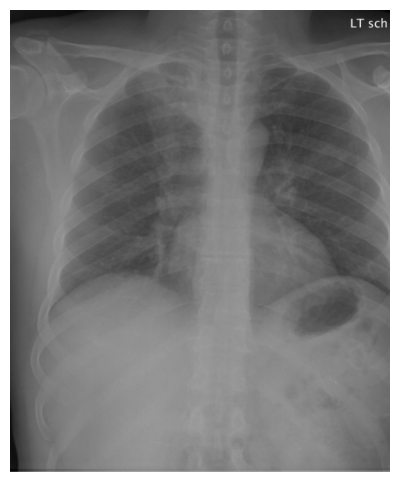

Generated report (beam):
 Findings: lungs clear . no focal airspace disease , pneumothorax or large pleural effusion . the heart size is normal . stable and soft tissues are within normal limits for prominent right hemidiaphragm compared to prior exam with cabg ct scan would be helpful . 1 . no evidence of active abnormality .
Impression: 


In [32]:
report_beam = trainer.generate_report_manual(
    image_input=["/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1000_IM-0003-1001.png"],
    show_image=True,
    generation_config=generation_config_beam,
)

print("Generated report (beam):\n", report_beam)

In [33]:
# from torch.utils.data import ConcatDataset, DataLoader
# from PIL import Image
# from nltk.tokenize import word_tokenize
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# from nltk.translate.meteor_score import single_meteor_score
# from rouge_score import rouge_scorer
# from tqdm import tqdm
# import pandas as pd
# def evaluate_dataloader_metrics_v2(dataloader, trainer, tokenizer, device, max_samples=None):
#     results = []
#     sample_count = 0
#     smooth = SmoothingFunction()
#     rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

#     for batch in tqdm(dataloader, desc="Evaluating dataset"):
#         input_ids = batch['input_ids']
#         image_paths_list = batch['image_paths']  # <- list of lists: one per sample

#         for i in range(len(image_paths_list)):
#             if max_samples and sample_count >= max_samples:
#                 break

#             gt_input_ids = input_ids[i]
#             if tokenizer.pad_token_id is not None:
#                 gt_input_ids = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
#             reference_text = tokenizer.decode(gt_input_ids, skip_special_tokens=True)
#             if not isinstance(reference_text, str) or len(reference_text.strip()) == 0:
#                 continue

#             # --- Load all image views for this report ---
#             pil_imgs = []
#             for image_path in image_paths_list[i]:
#                 pil_img = Image.open(image_path).convert('RGB')
#                 pil_imgs.append(pil_img)
#             # --- Generate report from all images for this study ---
#             gen_report = trainer.robust_generate_radiology_report(
#                 pil_imgs,
#                 max_tokens=350,
#                 deterministic=True,
#                 beam_width=1,
#             )
            
            
#             # --- TOKENIZATION FOR METRICS ---
#             ref_tokens = word_tokenize(reference_text)
#             hyp_tokens = word_tokenize(gen_report)
#             # BLEU scores for n = 1, 2, 3, 4
#             bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
#             bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
#             bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
#             bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1)

#             # METEOR (pass as strings, NOT as lists)
#             meteor = single_meteor_score(ref_tokens, hyp_tokens)


#             # ROUGE-L
#             rouge_l_score = rouge.score(reference_text, gen_report)['rougeL'].fmeasure

#             results.append({
#                 'BLEU-1': bleu1,
#                 'BLEU-2': bleu2,
#                 'BLEU-3': bleu3,
#                 'BLEU-4': bleu4,
#                 'METEOR': meteor,
#                 'ROUGE-L': rouge_l_score
#             })
#             sample_count += 1
#             if max_samples and sample_count >= max_samples:
#                 break
#         if max_samples and sample_count >= max_samples:
#             break

#     results_df = pd.DataFrame(results)
#     avg_scores = results_df.mean().to_dict()
#     return results_df, avg_scores

# # --- Example usage ---
# results_df, avg_scores = evaluate_dataloader_metrics_v2(test_loader, trainer, tokenizer, train_config.device)
# print(results_df)
# print('Average Scores:', avg_scores)


In [34]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import random

def evaluate_on_val_samples(trainer, val_loader, tokenizer, num_samples=5):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Get a single batch from val_loader
    sample_batch = next(iter(val_loader))
    images_batch = sample_batch['images']  # (batch, max_views, 3, H, W)
    input_ids = sample_batch['input_ids']
    image_paths_batch = sample_batch['image_paths']  # list of lists

    total_samples = min(num_samples, images_batch.size(0))
    selected_indices = random.sample(range(images_batch.size(0)), total_samples)

    for idx in selected_indices:
        images_tensor_list = []
        pil_imgs = []
        # Visualize all views per sample, skip padded views if a view_mask exists
        if 'view_mask' in sample_batch:
            view_mask = sample_batch['view_mask'][idx]  # (max_views,)
        else:
            view_mask = [1] * images_batch.size(1)
        for view_idx in range(images_batch.size(1)):
            if view_mask[view_idx] == 0:
                continue  # skip padded images
            image_tensor = images_batch[idx, view_idx].cpu()
            image_disp = (image_tensor * std) + mean
            image_disp = torch.clamp(image_disp, 0, 1)
            pil_img = transforms.ToPILImage()(image_disp)
            pil_imgs.append(pil_img)
            images_tensor_list.append(image_tensor)

        # Plot all views in a row
        num_views = len(pil_imgs)
        plt.figure(figsize=(5 * num_views, 5))
        for i, img in enumerate(pil_imgs):
            plt.subplot(1, num_views, i+1)
            plt.imshow(img)
            plt.title(f"View {i+1}")
            plt.axis('off')
        plt.show()

        # Decode ground truth report
        ground_truth_ids = input_ids[idx]
        ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

        # Generate report from all views using robust_generate_radiology_report
        generated_report = trainer.generate_report_manual(
            image_input=pil_imgs,
            generation_config=generation_config_sampling,
        
        )
        generated_report_v2 = trainer.generate_report_manual(
            image_input=pil_imgs,
            generation_config=generation_config_creative,
        
        )
        generated_report_v3 = trainer.generate_report_manual(
            image_input=pil_imgs,
            generation_config=generation_config_beam,
        
        )
        generated_report_v4 = trainer.generate_report_manual(
            image_input=pil_imgs,
            generation_config=generation_config_refined,
        
        )
        generated_report_v5 = trainer.generate_report_manual(
            image_input=pil_imgs,
            generation_config=generation_config_clinical,
        
        )


        print(f"\n--- Ground Truth Report ---\n{ground_truth_report.strip()}")
        print(f"\n--- Generated Report-generation_config_sampling ---\n{generated_report.strip()}")
        print(f"\n--- Generated Report_v2-generation_config_creative ---\n{generated_report_v2.strip()}")
        print(f"\n--- Generated Report_v3 -generation_config_beam---\n{generated_report_v3.strip()}")
        print(f"\n--- Generated Report_v4 -generation_config_refined---\n{generated_report_v4.strip()}")
        print(f"\n--- Generated Report_v5 -generation_config_clinical---\n{generated_report_v5.strip()}")
        print("-" * 80)

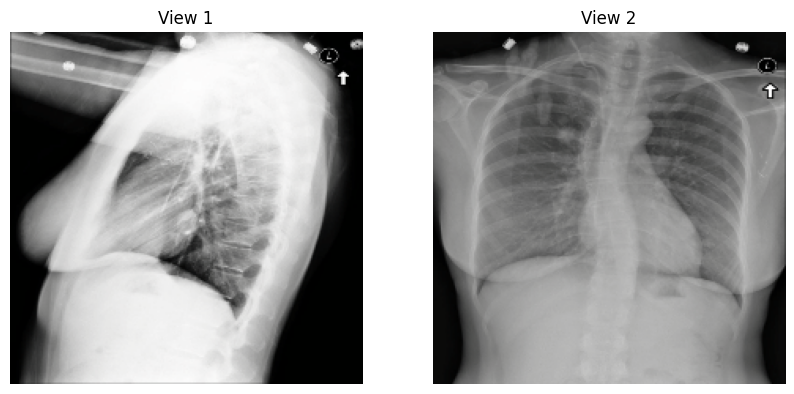


--- Ground Truth Report ---
there are bilateral pulmonary nodules whose appearances suggest metastatic disease to lungs . in the right lung , there is a 1 . 9 x 2 . 1 cm nodule overlying the posterior right 6th rib . there is a 1 . 0 x 1 . 2 cm nodule above this in the interspace between the posterior 5th and 6th ribs on the right . there is a 1 . 0 x 1 . 1 cm nodule projecting through the left 9th and 10th interspaces on the pa view . if not already performed , contrast-enhanced would be suited to evaluate these findings . there are no focal airspace opacities to suggest pneumonia . to the stomach contours appear grossly clear . heart size and pulmonary appear normal . there are left-sided axillary clips . there is a right internal jugular central catheter , the distal tip in right atrium .  1 . bilateral pulmonary nodules suggesting pulmonary metastases 2 . right internal jugular central catheter , the distal tip in the right atrium .

--- Generated Report-generation_config_sampling

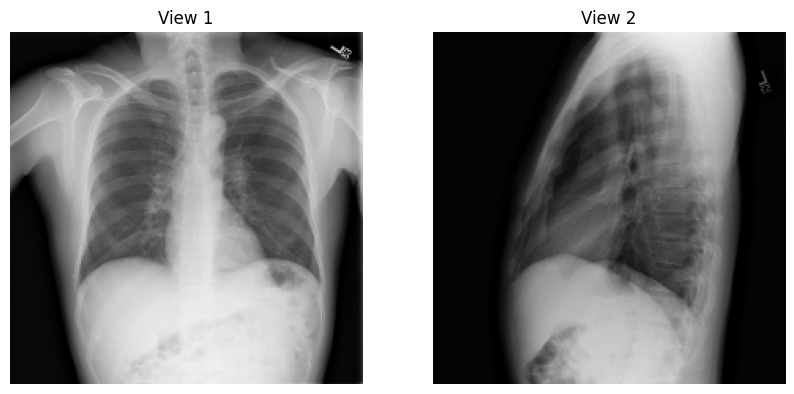


--- Ground Truth Report ---
heart size within normal limits , stable mediastinal and hilar contours . no alveolar consolidation , no findings of pleural effusion or pulmonary edema . no pneumothorax . small rounded bilateral axillary densities not seen on the previous exam most suggestive of artifacts , healed right lateral 10th rib fracture noted . .  no acute cardiopulmonary findings

--- Generated Report-generation_config_sampling ---
Findings: the heart size and mediastinal contour within normal limits for technique , right lower claterally . otherwise grossly clear lungs are well-expanded . no focal airspace disease . there is no pleural effusion or pneumothorax . the visualized chest show mediastinum . skeletal structures reveal no active disease . 1 . otherwise unremarkable lucency of the cortex with a typical location of prior granulomatous process . calcified lymphadenopathy within one that has com4cystectomy through the anterior nonemergent images from today view there are m

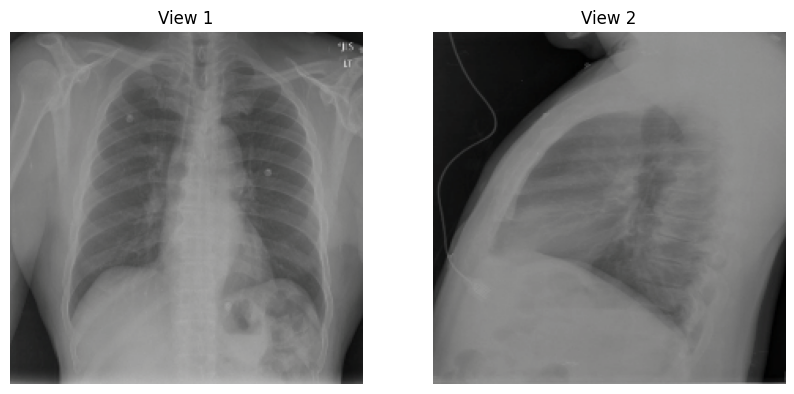


--- Ground Truth Report ---
cardiomediastinal silhouette demonstrates normal heart size with tortuosity and atherosclerosis of the thoracic aorta . no focal consolidation , pneumothorax , or pleural effusion . no acute bony abnormality identified . multilevel degenerative disc disease of the thoracic spine noted .  no acute cardiopulmonary abnormality .

--- Generated Report-generation_config_sampling ---
Findings: the heart size and mediastinal contours are normal . no focal airspace disease , large pleural effusion or pneumothorax . no acute cardiopulmonary abnormality .
Impression:

--- Generated Report_v2-generation_config_creative ---
Findings: the lungs are clear bilaterally . clear with large , or masses . heart size is normal in tortuous . aorta is again noted . stable compared to clinical demonstrate large mediastinal lymphadenopathy , unchanged from prior exams from comparison these as enly from clum film . 1 . no evidence of any cardiopulmonary disease .
Impression:

--- Ge

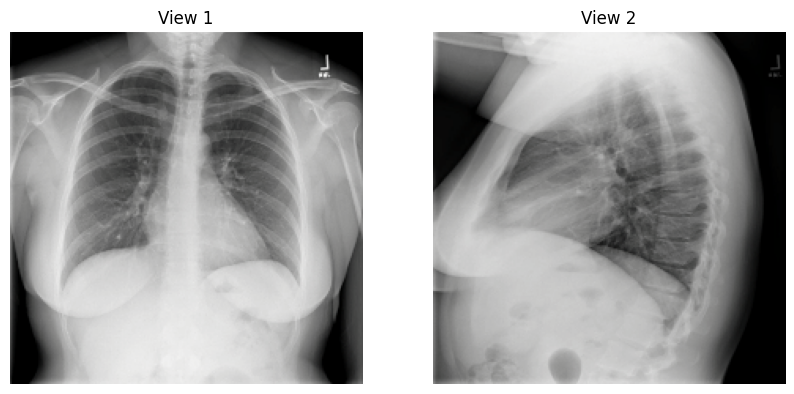


--- Ground Truth Report ---
the lungs and pleural spaces show no acute abnormality . heart size and pulmonary vascularity within normal limits .  1 . no acute pulmonary abnormality .

--- Generated Report-generation_config_sampling ---
Findings: the cardiomediastinal silhouette is unremarkable . no focal areas of consolidation , airspace disease . no pleural effusion or pneumothorax . there are small degenerative changes within normal limits for alignment noted within normal limits for prominent without evidence for free intraperitoneal air under tip at previous choly imy edema . thoracic visualized , age-indeterminate early smooth or masses . 1 . no acute abnormality . otherwise and clear pulmonary disease .
Impression:

--- Generated Report_v2-generation_config_creative ---
Findings: the cardiomediastinal silhouette is normal for soft tissue in size within normal limits for a paratracheal masses . otherwise no focal airspace disease . typical findings of any active processs . modera

In [35]:
evaluate_on_val_samples(trainer, test_loader, tokenizer, num_samples=5)

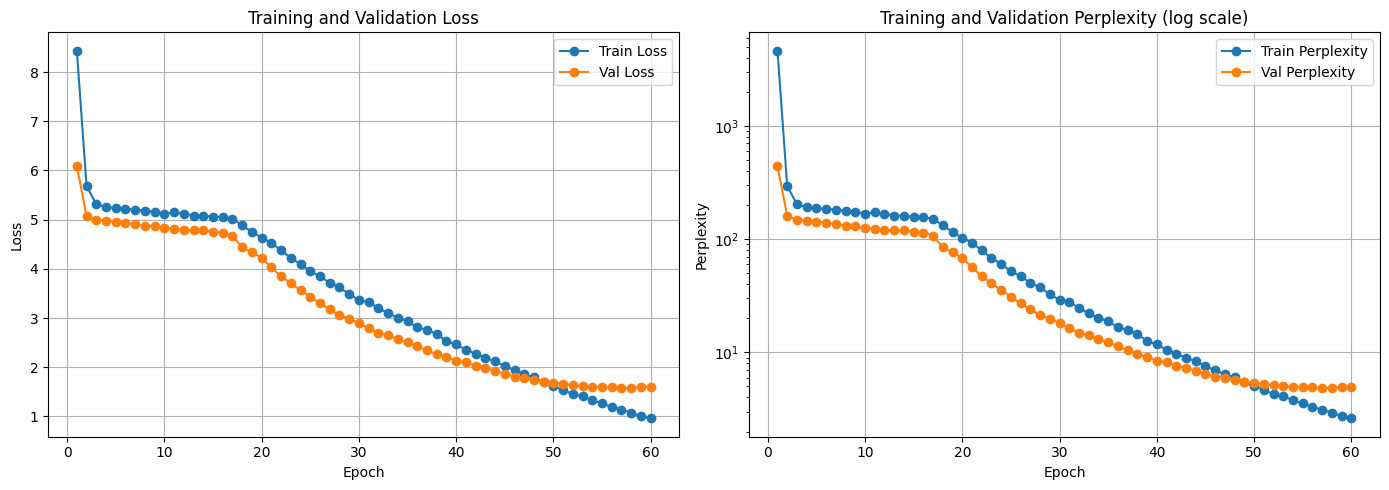

In [36]:
trainer.plot_loss_and_perplexity()